# Import library

Import the relevant python library

In [ ]:
import datetime, os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from utils.utils import DIAGNOSIS, EarlyStopping, RMSE, MSE, MAE, MAPE
from utils.loaddataset import DataSet
from model.net import DKNN

# Hyperparameter

Setting the hyperparameters

In [2]:
datafile ='SRF5s1_112_rand0.05s10_s5.csv'  #  sampled dataset in folder "Data/dataset". 
# The example "SRF5s1_112_rand0.05s10_s5.csv" denotes sampling at a rate of 5%, with a random seed of 10, from the random field "SRF5s1_112.csv", further partitioned into training and testing sets using a random seed of 5.

batch_size = 128  # batch size
lr = 0.0001  # learning rate
hidden_neurons = [4, 256, 16]  # [input dimension, model dimension, trend dimension]. Note that the input dimension should be equal to the number of all variables (auxiliary and target) in the dataset
pe_weight = 0.8  # weight of positional vector 
top_k = 400  # top k nearest neighbors
loss_type = 'rmse'  # loss function type, default: rmse, options: rmse, mse, mae, mape
optim_type='adam'  # optimizer type, default: adam, options: adam, sgd
if_summary = True  # if save the training summary or not

# Test if GPU working or not

Test for GPU and cuda acceleration, if not use cpu for training

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(device)

cuda:0


# Read data

Read the sampled dataset. Data format required: csv file, columns are organised as: id, coodx, coody, auxiliary variables (q in total, each variable corresponds to a column), target variable, and the dataset type (the last column).

In [4]:
datapath = './Data/dataset/' + datafile
# read the data
data = pd.read_csv(datapath)
print(data.head())

     id  coodx  coody        z1        z2        z3     target dataset
0   937     37      9  1.105420 -0.150936  0.183699   4.026431    test
1  9355     55     93  0.135998 -2.392647 -3.141612   7.740979    test
2  2293     93     22  2.819956  2.319428 -2.123234   9.742294   train
3   192     92      1  2.394848  3.182256 -7.373889   4.645330    test
4  8675     75     86 -0.621343 -0.263974  0.867634  12.388022   train


# Preprocessing  data

Data is loaded and scaled by the DataSet class to get a dataset instance. The training and test sets are obtained and converted to dataloader. As an interpolation model, DKNN treats the training set as known points  (observed locations), based on which the values of interest of the unknown points (unobserved locations) is estimated.

In [5]:
# Load data via class DataSet
dataset = DataSet(data)

# Scaling the data
data_scaler = dataset.scaler_data()

# get the scaled train data and  test data
data_train_scaler = data_scaler['train']
data_test_scaler = data_scaler['test']
print('data_train_scaler:')
print(data_train_scaler.describe())

# get the dataloader
train_dataloader = DataLoader(data_train_scaler.values.astype(float), shuffle=True, batch_size=batch_size, drop_last=False)
test_dataloader = DataLoader(data_test_scaler.values.astype(float), shuffle=False, batch_size=batch_size, drop_last=False) 

# Take the training set as known point data (observed locations)
known_coods_scaler = data_train_scaler.values[:, 1:3]
known_feature_scaler = data_train_scaler.values[:, 3:]

# tramsform the data to tensor
known_coods_scaler = torch.from_numpy((known_coods_scaler.astype(float))).to(torch.float32).to(device)
known_feature_scaler = torch.from_numpy(known_feature_scaler.astype(float)).to(torch.float32).to(device)

data_train_scaler:
               id       coodx       coody          z1            z2  \
count  400.000000  400.000000  400.000000  400.000000  4.000000e+02   
mean   199.500000    0.497904    0.453081    0.000000 -3.108624e-17   
std    115.614301    0.298986    0.288832    1.001252  1.001252e+00   
min      0.000000    0.000000    0.000000   -3.209412 -2.304838e+00   
25%     99.750000    0.232323    0.199495   -0.551142 -7.105072e-01   
50%    199.500000    0.515152    0.414141    0.148037  3.256333e-02   
75%    299.250000    0.757576    0.696970    0.662290  5.711694e-01   
max    399.000000    1.000000    1.000000    2.859259  2.797601e+00   

                 z3        target  
count  4.000000e+02  4.000000e+02  
mean  -8.881784e-18  5.107026e-17  
std    1.001252e+00  1.001252e+00  
min   -3.326120e+00 -1.875793e+00  
25%   -5.125156e-01 -7.698804e-01  
50%    1.658150e-01  2.206906e-02  
75%    6.468011e-01  7.073807e-01  
max    2.350142e+00  2.192478e+00  


# DKNN model initialization

DKNN model initialisation, defining the DKNN model structure based on hyperparameters and calculating the positional embeddings in advance, in order to avoid redundant calculations during the training process and to improve the training efficiency

In [6]:
# Define the DKNN model 
modelname = 'DKNN'
d_input, d_model, d_trend = hidden_neurons
model = DKNN(d_input=d_input, d_model=d_model, known_num=dataset.train_num, d_trend=d_trend, top_k=top_k, pe_weight=pe_weight)

# Calculate positional embeddings before training to increase the speed of training
model.cal_pe_know(known_feature_scaler, known_coods_scaler)
model.cal_pe_unknow(torch.from_numpy(data_test_scaler.values[:, 3:3+d_input].astype(float)).to(torch.float32).to(device),
                    torch.from_numpy(data_test_scaler.values[:, 1:3].astype(float)).to(torch.float32).to(device)) 
model.to(device)

DKNN(
  (AttRe): Attribute_Rep(
    (dense1): Dense(
      (fc): Linear(in_features=4, out_features=256, bias=True)
    )
    (dense2): Dense(
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (dense3): Dense(
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (relu): PReLU(num_parameters=1)
  )
  (Pgrn): PGRN(
    (dense1): Dense(
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (dense12): Dense(
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (dense2): Dense(
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (dense3): Dense(
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (sigmoid): Sigmoid()
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Ssan): SSAN(
    (map_query): Linear(in_features=256, out_features=256, bias=False)
    (map_key): Linear(in_features=256, out_features=256, bias=

# Training

Model training based on sampled dataset

## Loss function and optimizer

Defining loss functions and optimizers based on hyperparameters

In [7]:
##### loss function ##### 
if loss_type=='mae':
    criterion = MAE()
elif loss_type=='mse':
    criterion = MSE()
elif loss_type=='rmse':
    criterion = RMSE()
elif loss_type=='mape':
    criterion = MAPE()

##### optimizer #####
if optim_type=='adam':
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)
elif optim_type=='sgd':
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0)
    
# learning rate decay 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8,  verbose=True, patience=5, min_lr=1e-6)


## Build a SummaryWriter base on TensorBoard

Determine whether to build a SummaryWriter based on the TensorBoard library according to the hyperparameter if_summary

In [8]:
# get the datafile name
datafile = datapath[datapath.rfind('/')+1:]
datafilename = datafile[0:datafile.rfind('.')]

# get the save path
start_time = datetime.datetime.now()
train_info = start_time.strftime("%m%d_%H%M%S")
save_dir = './results/' +  modelname + '/' + datafilename + '/' + train_info

# get the summary path and build the summarywriter
if if_summary:
    summarypath = save_dir + '/summary/'
    writer = SummaryWriter(summarypath)
    print('summary path: \n' + summarypath)

summary path: 
./results/DKNN/SRF5s1_112_rand0.05s10_s5/0408_153945/summary/


## Training process

Iterate for model training and save the best model parameters

In [9]:
##### early stopping #####
patience = 30
early_stopping = EarlyStopping(patience, verbose=True)

##### start train #####
total_train_step = 0
min_loss, best_epoch = float('inf'), float('inf')
best_rmse_inverse,best_mae_inverse,best_mape_inverse = float('inf'),float('inf'),float('inf')

print(train_info + '  start')
epoch = 300
for e in tqdm(range(epoch)):

    ##### training #####
    total_train_loss = 0
    train_num = 0
    model.train()  
    for step, i in enumerate(train_dataloader):
        
        # get the model input
        i = i.to(torch.float32)
        input_pe = model.pe_know[i[:,0].type(torch.long)]
        input_coods = i[:, 1:3].to(device)
        input_feature = i[:, 3:3+d_input].to(device)
        input_feature[:,-1] = 0
        
        # model execution
        optimizer.zero_grad()
        output, _ = model(input_coods, input_feature, input_pe, known_coods_scaler, known_feature_scaler)

        # calculate loss and optimize the model
        target = i[:, -1].to(device)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # diagnose the output
        diag = DIAGNOSIS(output, target)
        l_rmse, l_mse, l_mae, l_mape = diag.get()
        
        # tensorboard summary
        if if_summary:
            total_train_step = total_train_step + 1
            writer.add_scalar("train_loss", loss, total_train_step)
            writer.add_scalar("train_rmse", l_rmse, total_train_step)
            writer.add_scalar("train_mae", l_mae, total_train_step)
            writer.add_scalar("train_mape", l_mape, total_train_step)
        
        # print the training log
        total_train_loss = total_train_loss + loss.item()
        train_num +=1
        if step % 3 == 0:
            print('\n--------train epoch {},step {},loss: {:.5f}, RMSE:{:.5f},MSE:{:.5f}, MAE:{:.5f}, MAPE:{:.5f}--'
                    .format(e, step, loss.item(), l_rmse, l_mse, l_mae, l_mape))
    
    # tensorboard summary
    total_train_loss = total_train_loss/train_num
    if if_summary:
        writer.add_scalar("total_train_loss", total_train_loss, e)

    ##### testing #####
    total_test_loss, l2p, l3p, l4p = 0, 0, 0, 0
    lrmse_inverse,lmae_inverse,lmape_inverse = 0,0,0
    test_num = 0
    with torch.no_grad():
        model.eval()  # set the model to evaluation mode
        for step, i in enumerate(test_dataloader):

            # get the model input
            i = i.to(torch.float32)
            input_pe = model.pe_unknow[i[:,0].type(torch.long)]
            input_coods = i[:, 1:3].to(device)
            input_feature = i[:, 3:3+d_input].to(device)
            input_feature[:,-1] = 0
            
            # model execution
            output, _ = model(input_coods, input_feature, input_pe, known_coods_scaler, known_feature_scaler)
            
            # diagnose the output
            target = i[:, -1].to(device)
            test_loss = criterion(output, target)
            test_diag = DIAGNOSIS(output, target)
            t_rmse, t_mse, _, t_mape = test_diag.get()
            total_test_loss += test_loss.item()
            l2p += t_rmse
            l3p += t_mse
            l4p += t_mape
            
            # inverse the scaled output and calculate the diagnosis
            output_inverse = dataset.scaler_label.inverse_transform(output.cpu().reshape(-1, 1))
            target_inverse = dataset.scaler_label.inverse_transform(target.cpu().reshape(-1, 1))
            test_diag_inverse = DIAGNOSIS(output_inverse, target_inverse)
            lrmse_inverse += test_diag_inverse.v_rmse
            lmae_inverse += test_diag_inverse.v_mae
            lmape_inverse += test_diag_inverse.v_mape

            test_num = test_num + 1

        # calculate the final result
        final_loss = total_test_loss / test_num
        final_rmse = l2p / test_num
        final_mse = l3p / test_num
        final_mape = l4p / test_num
        final_rmse_inverse = lrmse_inverse / test_num
        final_mae_inverse = lmae_inverse / test_num
        final_mape_inverse = lmape_inverse / test_num

        # adjust learning rate 
        scheduler.step(final_loss)

        # tensorboard summary
        if if_summary:
            writer.add_scalar("total_test_loss", final_loss, e)
            writer.add_scalar('lr', optimizer.state_dict()['param_groups'][0]['lr'], e)

        # print the log
        end_time = datetime.datetime.now()
        print('--------test loss: {:.5f}, RMSE:{:.5f},MSE:{:.5f}, MAPE:{:.5f}, RMSE_inv:{:.5f}, epoch time:{:.2f}m--'
            .format(final_loss, final_rmse, final_mse, final_mape, final_rmse_inverse, (end_time-start_time).seconds/60))
        
        # save the best model parameters and info
        if final_loss < min_loss:
            min_loss = final_loss
            best_epoch = e
            best_rmse_inverse = final_rmse_inverse
            best_mae_inverse = final_mae_inverse
            best_mape_inverse = final_mape_inverse
            
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            
            # save the model parameters
            torch.save(model.state_dict(), save_dir + '/checkpoint.pth')
            
            # save the model info
            with open(save_dir + '/checkpoint_info.txt', 'w') as f:
                f.write('-----------model_info-------------')
                f.write('\rmodel name:  dknn\r')
                f.write('train info:  {}\r'.format(train_info))
                f.write('min loss:  {}\r'.format(min_loss))
                f.write('best_epoch:  {}\r'.format(best_epoch))
                f.write('best_rmse_inverse:  {}\r'.format(best_rmse_inverse))
                f.write('best inverse MAE/RMSE/MAPE: {:.2f}/{:.2f}/{:.2f}%\r'
                    .format(best_mae_inverse,best_rmse_inverse,best_mape_inverse*100))
                f.write('spend time: {} minutes\r'.format((datetime.datetime.now()-start_time).seconds/60))
                f.write('epoch: {}\r'.format(e))
        
        ##### early stopping #####
        early_stopping(final_loss, model, save_model_dir=None)
        if early_stopping.early_stop:
            print("Early stopping")
            break

# close the tensorboard summary
if if_summary:
    writer.close()

print(train_info + '  end')

0408_153945  start


  0%|          | 0/300 [00:00<?, ?it/s]


--------train epoch 0,step 0,loss: 12.78273, RMSE:12.78273,MSE:163.39810, MAE:10.38738, MAPE:41.43253--

--------train epoch 0,step 3,loss: 8.44687, RMSE:8.44687,MSE:71.34966, MAE:7.05297, MAPE:37.96288--
--------test loss: 10.84069, RMSE:10.84069,MSE:117.52065, MAPE:27.10550, RMSE_inv:41.06104, epoch time:0.00m--


  0%|          | 1/300 [00:00<03:31,  1.42it/s]

loss decreased (inf --> 10.840694).  Saving model ...

--------train epoch 1,step 0,loss: 11.20895, RMSE:11.20895,MSE:125.64053, MAE:9.98404, MAPE:39.61548--

--------train epoch 1,step 3,loss: 6.58927, RMSE:6.58927,MSE:43.41850, MAE:6.45462, MAPE:11.29131--
--------test loss: 1.45158, RMSE:1.45158,MSE:2.10708, MAPE:5.16621, RMSE_inv:5.49811, epoch time:0.00m--


  1%|          | 3/300 [00:01<01:59,  2.49it/s]

loss decreased (10.840694 --> 1.451580).  Saving model ...

--------train epoch 2,step 0,loss: 1.58123, RMSE:1.58123,MSE:2.50028, MAE:1.41205, MAPE:5.58255--

--------train epoch 2,step 3,loss: 2.11554, RMSE:2.11554,MSE:4.47552, MAE:1.90525, MAPE:5.17203--
--------test loss: 3.42609, RMSE:3.42609,MSE:11.73808, MAPE:17.46070, RMSE_inv:12.97691, epoch time:0.02m--
EarlyStopping counter: 1 out of 30

--------train epoch 3,step 0,loss: 2.84692, RMSE:2.84692,MSE:8.10496, MAE:2.45697, MAPE:10.97979--


  1%|▏         | 4/300 [00:01<01:32,  3.20it/s]


--------train epoch 3,step 3,loss: 1.43507, RMSE:1.43507,MSE:2.05943, MAE:1.26686, MAPE:2.89337--
--------test loss: 2.74090, RMSE:2.74090,MSE:7.51254, MAPE:11.10899, RMSE_inv:10.38165, epoch time:0.02m--
EarlyStopping counter: 2 out of 30

--------train epoch 4,step 0,loss: 2.34991, RMSE:2.34991,MSE:5.52207, MAE:1.94113, MAPE:7.71114--

--------train epoch 4,step 3,loss: 1.49258, RMSE:1.49258,MSE:2.22781, MAE:1.38501, MAPE:5.67126--
--------test loss: 0.83165, RMSE:0.83165,MSE:0.69163, MAPE:3.94483, RMSE_inv:3.15000, epoch time:0.02m--


  2%|▏         | 5/300 [00:02<01:52,  2.63it/s]

loss decreased (1.451580 --> 0.831646).  Saving model ...

--------train epoch 5,step 0,loss: 0.81990, RMSE:0.81990,MSE:0.67223, MAE:0.72128, MAPE:1.97391--


  2%|▏         | 6/300 [00:02<01:38,  2.97it/s]


--------train epoch 5,step 3,loss: 0.74595, RMSE:0.74595,MSE:0.55645, MAE:0.59768, MAPE:2.92236--
--------test loss: 1.24473, RMSE:1.24473,MSE:1.54936, MAPE:5.83612, RMSE_inv:4.71464, epoch time:0.03m--
EarlyStopping counter: 1 out of 30

--------train epoch 6,step 0,loss: 1.28829, RMSE:1.28829,MSE:1.65970, MAE:1.21977, MAPE:4.28422--

--------train epoch 6,step 3,loss: 0.65668, RMSE:0.65668,MSE:0.43122, MAE:0.56039, MAPE:2.41105--


  2%|▏         | 7/300 [00:02<01:25,  3.44it/s]

--------test loss: 0.95940, RMSE:0.95940,MSE:0.92044, MAPE:3.81431, RMSE_inv:3.63388, epoch time:0.03m--
EarlyStopping counter: 2 out of 30

--------train epoch 7,step 0,loss: 0.90475, RMSE:0.90475,MSE:0.81857, MAE:0.81801, MAPE:2.48939--

--------train epoch 7,step 3,loss: 0.80458, RMSE:0.80458,MSE:0.64735, MAE:0.73941, MAPE:3.18134--
--------test loss: 0.78152, RMSE:0.78152,MSE:0.61078, MAPE:3.97294, RMSE_inv:2.96015, epoch time:0.03m--


  3%|▎         | 8/300 [00:03<01:55,  2.53it/s]

loss decreased (0.831646 --> 0.781523).  Saving model ...

--------train epoch 8,step 0,loss: 0.78935, RMSE:0.78935,MSE:0.62307, MAE:0.69808, MAPE:3.47572--

--------train epoch 8,step 3,loss: 0.70147, RMSE:0.70147,MSE:0.49206, MAE:0.63423, MAPE:2.11485--
--------test loss: 0.37325, RMSE:0.37325,MSE:0.13932, MAPE:1.47930, RMSE_inv:1.41375, epoch time:0.05m--


  3%|▎         | 9/300 [00:03<02:12,  2.20it/s]

loss decreased (0.781523 --> 0.373251).  Saving model ...

--------train epoch 9,step 0,loss: 0.38476, RMSE:0.38476,MSE:0.14804, MAE:0.30152, MAPE:1.02230--

--------train epoch 9,step 3,loss: 0.22546, RMSE:0.22546,MSE:0.05083, MAE:0.19776, MAPE:1.93633--
--------test loss: 0.78658, RMSE:0.78658,MSE:0.61871, MAPE:3.02357, RMSE_inv:2.97930, epoch time:0.05m--
EarlyStopping counter: 1 out of 30


  4%|▎         | 11/300 [00:04<01:33,  3.09it/s]


--------train epoch 10,step 0,loss: 0.72787, RMSE:0.72787,MSE:0.52980, MAE:0.65349, MAPE:2.93435--

--------train epoch 10,step 3,loss: 0.66278, RMSE:0.66278,MSE:0.43927, MAE:0.54862, MAPE:1.77289--
--------test loss: 0.56746, RMSE:0.56746,MSE:0.32201, MAPE:2.06608, RMSE_inv:2.14936, epoch time:0.07m--
EarlyStopping counter: 2 out of 30

--------train epoch 11,step 0,loss: 0.46856, RMSE:0.46856,MSE:0.21955, MAE:0.38927, MAPE:1.12449--


  4%|▍         | 12/300 [00:04<01:23,  3.45it/s]


--------train epoch 11,step 3,loss: 0.42820, RMSE:0.42820,MSE:0.18336, MAE:0.35598, MAPE:0.82157--
--------test loss: 0.78498, RMSE:0.78498,MSE:0.61620, MAPE:3.47973, RMSE_inv:2.97326, epoch time:0.07m--
EarlyStopping counter: 3 out of 30

--------train epoch 12,step 0,loss: 0.83141, RMSE:0.83141,MSE:0.69124, MAE:0.73633, MAPE:2.42764--


  4%|▍         | 13/300 [00:04<01:17,  3.68it/s]


--------train epoch 12,step 3,loss: 0.68172, RMSE:0.68172,MSE:0.46475, MAE:0.60434, MAPE:2.31570--
--------test loss: 0.86006, RMSE:0.86006,MSE:0.73970, MAPE:4.26434, RMSE_inv:3.25762, epoch time:0.07m--
EarlyStopping counter: 4 out of 30

--------train epoch 13,step 0,loss: 0.83637, RMSE:0.83637,MSE:0.69952, MAE:0.74407, MAPE:3.31263--

--------train epoch 13,step 3,loss: 0.65057, RMSE:0.65057,MSE:0.42325, MAE:0.54633, MAPE:3.95215--


  5%|▌         | 15/300 [00:04<01:04,  4.42it/s]

--------test loss: 0.38120, RMSE:0.38120,MSE:0.14532, MAPE:1.52906, RMSE_inv:1.44388, epoch time:0.07m--
EarlyStopping counter: 5 out of 30

--------train epoch 14,step 0,loss: 0.42167, RMSE:0.42167,MSE:0.17780, MAE:0.33681, MAPE:2.48255--

--------train epoch 14,step 3,loss: 0.40080, RMSE:0.40080,MSE:0.16064, MAE:0.30194, MAPE:0.77936--
Epoch 00015: reducing learning rate of group 0 to 8.0000e-05.
--------test loss: 0.83017, RMSE:0.83017,MSE:0.68919, MAPE:3.35327, RMSE_inv:3.14443, epoch time:0.07m--
EarlyStopping counter: 6 out of 30


  5%|▌         | 16/300 [00:05<01:00,  4.71it/s]


--------train epoch 15,step 0,loss: 0.73757, RMSE:0.73757,MSE:0.54402, MAE:0.63908, MAPE:1.84240--

--------train epoch 15,step 3,loss: 0.57131, RMSE:0.57131,MSE:0.32639, MAE:0.50714, MAPE:3.62969--
--------test loss: 0.90318, RMSE:0.90318,MSE:0.81574, MAPE:3.94577, RMSE_inv:3.42097, epoch time:0.08m--
EarlyStopping counter: 7 out of 30

--------train epoch 16,step 0,loss: 0.79053, RMSE:0.79053,MSE:0.62493, MAE:0.67124, MAPE:3.39720--


  6%|▌         | 17/300 [00:05<00:59,  4.78it/s]


--------train epoch 16,step 3,loss: 0.46363, RMSE:0.46363,MSE:0.21495, MAE:0.37674, MAPE:1.27769--
--------test loss: 0.58561, RMSE:0.58561,MSE:0.34294, MAPE:2.65315, RMSE_inv:2.21811, epoch time:0.08m--
EarlyStopping counter: 8 out of 30

--------train epoch 17,step 0,loss: 0.53906, RMSE:0.53906,MSE:0.29058, MAE:0.44538, MAPE:1.29853--

--------train epoch 17,step 3,loss: 0.45454, RMSE:0.45454,MSE:0.20661, MAE:0.34770, MAPE:2.46942--
--------test loss: 0.29350, RMSE:0.29350,MSE:0.08614, MAPE:0.95014, RMSE_inv:1.11167, epoch time:0.08m--


  6%|▌         | 18/300 [00:05<01:26,  3.28it/s]

loss decreased (0.373251 --> 0.293497).  Saving model ...

--------train epoch 18,step 0,loss: 0.30844, RMSE:0.30844,MSE:0.09513, MAE:0.23709, MAPE:0.77191--

--------train epoch 18,step 3,loss: 0.36030, RMSE:0.36030,MSE:0.12982, MAE:0.31540, MAPE:3.40032--
--------test loss: 0.38568, RMSE:0.38568,MSE:0.14875, MAPE:0.96655, RMSE_inv:1.46083, epoch time:0.10m--
EarlyStopping counter: 1 out of 30


  7%|▋         | 20/300 [00:06<01:11,  3.92it/s]


--------train epoch 19,step 0,loss: 0.41745, RMSE:0.41745,MSE:0.17426, MAE:0.33697, MAPE:1.33458--

--------train epoch 19,step 3,loss: 0.38617, RMSE:0.38617,MSE:0.14912, MAE:0.31957, MAPE:1.89480--
--------test loss: 0.45802, RMSE:0.45802,MSE:0.20978, MAPE:1.17942, RMSE_inv:1.73482, epoch time:0.10m--
EarlyStopping counter: 2 out of 30

--------train epoch 20,step 0,loss: 0.41237, RMSE:0.41237,MSE:0.17005, MAE:0.32096, MAPE:0.87476--


  7%|▋         | 21/300 [00:06<01:07,  4.10it/s]


--------train epoch 20,step 3,loss: 0.22419, RMSE:0.22419,MSE:0.05026, MAE:0.19275, MAPE:0.62009--
--------test loss: 0.32779, RMSE:0.32779,MSE:0.10745, MAPE:1.85854, RMSE_inv:1.24156, epoch time:0.10m--
EarlyStopping counter: 3 out of 30

--------train epoch 21,step 0,loss: 0.31552, RMSE:0.31552,MSE:0.09955, MAE:0.25662, MAPE:0.92788--

--------train epoch 21,step 3,loss: 0.32078, RMSE:0.32078,MSE:0.10290, MAE:0.26004, MAPE:3.65799--
--------test loss: 0.38881, RMSE:0.38881,MSE:0.15118, MAPE:1.25761, RMSE_inv:1.47270, epoch time:0.10m--
EarlyStopping counter: 4 out of 30


  7%|▋         | 22/300 [00:06<01:03,  4.41it/s]


--------train epoch 22,step 0,loss: 0.39832, RMSE:0.39832,MSE:0.15866, MAE:0.35650, MAPE:1.18416--

--------train epoch 22,step 3,loss: 0.38578, RMSE:0.38578,MSE:0.14883, MAE:0.33624, MAPE:0.63120--
--------test loss: 0.25632, RMSE:0.25632,MSE:0.06570, MAPE:0.75984, RMSE_inv:0.97086, epoch time:0.10m--


  8%|▊         | 23/300 [00:07<01:25,  3.25it/s]

loss decreased (0.293497 --> 0.256320).  Saving model ...

--------train epoch 23,step 0,loss: 0.24048, RMSE:0.24048,MSE:0.05783, MAE:0.19662, MAPE:0.70372--

--------train epoch 23,step 3,loss: 0.29998, RMSE:0.29998,MSE:0.08999, MAE:0.21429, MAPE:0.56753--
--------test loss: 0.24276, RMSE:0.24276,MSE:0.05893, MAPE:0.69332, RMSE_inv:0.91950, epoch time:0.12m--


  8%|▊         | 24/300 [00:07<01:43,  2.67it/s]

loss decreased (0.256320 --> 0.242761).  Saving model ...

--------train epoch 24,step 0,loss: 0.25605, RMSE:0.25605,MSE:0.06556, MAE:0.21094, MAPE:0.93457--

--------train epoch 24,step 3,loss: 0.19453, RMSE:0.19453,MSE:0.03784, MAE:0.16792, MAPE:0.36652--
--------test loss: 0.21334, RMSE:0.21334,MSE:0.04551, MAPE:0.62062, RMSE_inv:0.80806, epoch time:0.12m--


  8%|▊         | 25/300 [00:08<02:31,  1.82it/s]

loss decreased (0.242761 --> 0.213340).  Saving model ...

--------train epoch 25,step 0,loss: 0.19068, RMSE:0.19068,MSE:0.03636, MAE:0.15300, MAPE:0.74054--

--------train epoch 25,step 3,loss: 0.19866, RMSE:0.19866,MSE:0.03946, MAE:0.12885, MAPE:0.12447--
--------test loss: 0.25100, RMSE:0.25100,MSE:0.06300, MAPE:0.89698, RMSE_inv:0.95069, epoch time:0.13m--
EarlyStopping counter: 1 out of 30


  9%|▉         | 27/300 [00:09<01:39,  2.74it/s]


--------train epoch 26,step 0,loss: 0.23196, RMSE:0.23196,MSE:0.05381, MAE:0.18695, MAPE:0.72190--

--------train epoch 26,step 3,loss: 0.26289, RMSE:0.26289,MSE:0.06911, MAE:0.22732, MAPE:1.29977--
--------test loss: 0.25663, RMSE:0.25663,MSE:0.06586, MAPE:0.78528, RMSE_inv:0.97203, epoch time:0.15m--
EarlyStopping counter: 2 out of 30

--------train epoch 27,step 0,loss: 0.24397, RMSE:0.24397,MSE:0.05952, MAE:0.19761, MAPE:0.93093--


  9%|▉         | 28/300 [00:09<01:24,  3.22it/s]


--------train epoch 27,step 3,loss: 0.21649, RMSE:0.21649,MSE:0.04687, MAE:0.16878, MAPE:2.54602--
--------test loss: 0.35367, RMSE:0.35367,MSE:0.12508, MAPE:1.49198, RMSE_inv:1.33958, epoch time:0.15m--
EarlyStopping counter: 3 out of 30

--------train epoch 28,step 0,loss: 0.34495, RMSE:0.34495,MSE:0.11899, MAE:0.28451, MAPE:1.45659--

--------train epoch 28,step 3,loss: 0.23585, RMSE:0.23585,MSE:0.05563, MAE:0.19747, MAPE:0.67369--
--------test loss: 0.18896, RMSE:0.18896,MSE:0.03571, MAPE:0.80910, RMSE_inv:0.71574, epoch time:0.15m--


 10%|▉         | 29/300 [00:09<01:47,  2.52it/s]

loss decreased (0.213340 --> 0.188965).  Saving model ...

--------train epoch 29,step 0,loss: 0.16526, RMSE:0.16526,MSE:0.02731, MAE:0.13300, MAPE:0.47303--

--------train epoch 29,step 3,loss: 0.12994, RMSE:0.12994,MSE:0.01688, MAE:0.12111, MAPE:0.31105--


 10%|█         | 30/300 [00:10<01:34,  2.85it/s]

--------test loss: 0.28444, RMSE:0.28444,MSE:0.08091, MAPE:1.19693, RMSE_inv:1.07737, epoch time:0.17m--
EarlyStopping counter: 1 out of 30

--------train epoch 30,step 0,loss: 0.27623, RMSE:0.27623,MSE:0.07630, MAE:0.21318, MAPE:0.74355--

--------train epoch 30,step 3,loss: 0.29089, RMSE:0.29089,MSE:0.08461, MAE:0.26479, MAPE:1.58148--


 11%|█         | 32/300 [00:10<01:14,  3.59it/s]

--------test loss: 0.54514, RMSE:0.54514,MSE:0.29718, MAPE:1.99391, RMSE_inv:2.06481, epoch time:0.17m--
EarlyStopping counter: 2 out of 30

--------train epoch 31,step 0,loss: 0.48911, RMSE:0.48911,MSE:0.23922, MAE:0.42808, MAPE:2.05774--

--------train epoch 31,step 3,loss: 0.70443, RMSE:0.70443,MSE:0.49622, MAE:0.59218, MAPE:1.78235--
--------test loss: 0.34807, RMSE:0.34807,MSE:0.12115, MAPE:1.31264, RMSE_inv:1.31837, epoch time:0.17m--
EarlyStopping counter: 3 out of 30


 11%|█         | 33/300 [00:10<01:07,  3.94it/s]


--------train epoch 32,step 0,loss: 0.31030, RMSE:0.31030,MSE:0.09629, MAE:0.25844, MAPE:0.68797--

--------train epoch 32,step 3,loss: 0.46612, RMSE:0.46612,MSE:0.21727, MAE:0.32111, MAPE:0.46280--
--------test loss: 0.63443, RMSE:0.63443,MSE:0.40250, MAPE:3.48171, RMSE_inv:2.40302, epoch time:0.17m--
EarlyStopping counter: 4 out of 30

--------train epoch 33,step 0,loss: 0.61771, RMSE:0.61771,MSE:0.38156, MAE:0.51157, MAPE:2.13508--


 11%|█▏        | 34/300 [00:10<01:06,  4.01it/s]


--------train epoch 33,step 3,loss: 0.52000, RMSE:0.52000,MSE:0.27040, MAE:0.42879, MAPE:4.95770--
--------test loss: 0.74367, RMSE:0.74367,MSE:0.55305, MAPE:3.99468, RMSE_inv:2.81679, epoch time:0.17m--
EarlyStopping counter: 5 out of 30

--------train epoch 34,step 0,loss: 0.65479, RMSE:0.65479,MSE:0.42875, MAE:0.56648, MAPE:2.37942--

--------train epoch 34,step 3,loss: 0.64115, RMSE:0.64115,MSE:0.41107, MAE:0.52715, MAPE:2.13847--


 12%|█▏        | 36/300 [00:11<00:56,  4.65it/s]

Epoch 00035: reducing learning rate of group 0 to 6.4000e-05.
--------test loss: 1.65661, RMSE:1.65661,MSE:2.74435, MAPE:8.14087, RMSE_inv:6.27470, epoch time:0.18m--
EarlyStopping counter: 6 out of 30

--------train epoch 35,step 0,loss: 1.68885, RMSE:1.68885,MSE:2.85222, MAE:1.60303, MAPE:6.57291--

--------train epoch 35,step 3,loss: 0.46879, RMSE:0.46879,MSE:0.21976, MAE:0.38838, MAPE:0.90653--
--------test loss: 0.75997, RMSE:0.75997,MSE:0.57755, MAPE:2.33855, RMSE_inv:2.87850, epoch time:0.18m--
EarlyStopping counter: 7 out of 30

--------train epoch 36,step 0,loss: 0.81087, RMSE:0.81087,MSE:0.65751, MAE:0.73342, MAPE:3.79415--


 12%|█▏        | 37/300 [00:11<00:52,  4.98it/s]


--------train epoch 36,step 3,loss: 0.78666, RMSE:0.78666,MSE:0.61883, MAE:0.63459, MAPE:1.40082--
--------test loss: 0.85187, RMSE:0.85187,MSE:0.72569, MAPE:2.93013, RMSE_inv:3.22662, epoch time:0.18m--
EarlyStopping counter: 8 out of 30

--------train epoch 37,step 0,loss: 0.76611, RMSE:0.76611,MSE:0.58692, MAE:0.62580, MAPE:1.90843--

--------train epoch 37,step 3,loss: 0.76932, RMSE:0.76932,MSE:0.59185, MAE:0.66117, MAPE:2.88762--
--------test loss: 0.55524, RMSE:0.55524,MSE:0.30829, MAPE:2.49841, RMSE_inv:2.10306, epoch time:0.18m--
EarlyStopping counter: 9 out of 30


 13%|█▎        | 39/300 [00:11<00:46,  5.58it/s]


--------train epoch 38,step 0,loss: 0.57736, RMSE:0.57736,MSE:0.33335, MAE:0.46769, MAPE:3.50021--

--------train epoch 38,step 3,loss: 0.77295, RMSE:0.77295,MSE:0.59745, MAE:0.64971, MAPE:2.03818--
--------test loss: 0.72811, RMSE:0.72811,MSE:0.53015, MAPE:3.02548, RMSE_inv:2.75785, epoch time:0.18m--
EarlyStopping counter: 10 out of 30

--------train epoch 39,step 0,loss: 0.68778, RMSE:0.68778,MSE:0.47305, MAE:0.61913, MAPE:3.71391--


 14%|█▎        | 41/300 [00:12<00:42,  6.14it/s]


--------train epoch 39,step 3,loss: 0.71693, RMSE:0.71693,MSE:0.51399, MAE:0.66000, MAPE:3.00202--
--------test loss: 0.40334, RMSE:0.40334,MSE:0.16268, MAPE:1.81054, RMSE_inv:1.52772, epoch time:0.18m--
EarlyStopping counter: 11 out of 30

--------train epoch 40,step 0,loss: 0.48337, RMSE:0.48337,MSE:0.23365, MAE:0.36748, MAPE:1.95942--

--------train epoch 40,step 3,loss: 0.43523, RMSE:0.43523,MSE:0.18942, MAE:0.35024, MAPE:1.16028--
Epoch 00041: reducing learning rate of group 0 to 5.1200e-05.
--------test loss: 0.68047, RMSE:0.68047,MSE:0.46304, MAPE:1.63218, RMSE_inv:2.57741, epoch time:0.20m--
EarlyStopping counter: 12 out of 30

--------train epoch 41,step 0,loss: 0.58174, RMSE:0.58174,MSE:0.33842, MAE:0.46657, MAPE:1.26919--


 14%|█▍        | 42/300 [00:12<00:44,  5.81it/s]


--------train epoch 41,step 3,loss: 0.32135, RMSE:0.32135,MSE:0.10326, MAE:0.30101, MAPE:3.51604--
--------test loss: 0.42918, RMSE:0.42918,MSE:0.18420, MAPE:1.57640, RMSE_inv:1.62561, epoch time:0.20m--
EarlyStopping counter: 13 out of 30

--------train epoch 42,step 0,loss: 0.41505, RMSE:0.41505,MSE:0.17227, MAE:0.36860, MAPE:1.36299--


 14%|█▍        | 43/300 [00:12<00:49,  5.23it/s]


--------train epoch 42,step 3,loss: 0.39726, RMSE:0.39726,MSE:0.15781, MAE:0.34853, MAPE:0.82688--
--------test loss: 0.30260, RMSE:0.30260,MSE:0.09157, MAPE:1.39285, RMSE_inv:1.14615, epoch time:0.20m--
EarlyStopping counter: 14 out of 30

--------train epoch 43,step 0,loss: 0.26629, RMSE:0.26629,MSE:0.07091, MAE:0.22392, MAPE:0.71239--


 15%|█▍        | 44/300 [00:12<00:51,  5.00it/s]


--------train epoch 43,step 3,loss: 0.31229, RMSE:0.31229,MSE:0.09753, MAE:0.25915, MAPE:0.80393--
--------test loss: 0.35496, RMSE:0.35496,MSE:0.12600, MAPE:1.68547, RMSE_inv:1.34447, epoch time:0.20m--
EarlyStopping counter: 15 out of 30

--------train epoch 44,step 0,loss: 0.28824, RMSE:0.28824,MSE:0.08308, MAE:0.23087, MAPE:0.96966--

--------train epoch 44,step 3,loss: 0.39834, RMSE:0.39834,MSE:0.15867, MAE:0.31464, MAPE:0.62043--


 15%|█▌        | 46/300 [00:13<00:49,  5.12it/s]

--------test loss: 0.22484, RMSE:0.22484,MSE:0.05055, MAPE:1.01129, RMSE_inv:0.85162, epoch time:0.20m--
EarlyStopping counter: 16 out of 30

--------train epoch 45,step 0,loss: 0.19135, RMSE:0.19135,MSE:0.03661, MAE:0.15292, MAPE:0.73598--

--------train epoch 45,step 3,loss: 0.20834, RMSE:0.20834,MSE:0.04341, MAE:0.17077, MAPE:0.25915--
--------test loss: 0.24820, RMSE:0.24820,MSE:0.06160, MAPE:1.23123, RMSE_inv:0.94011, epoch time:0.22m--
EarlyStopping counter: 17 out of 30


 16%|█▌        | 47/300 [00:13<00:49,  5.14it/s]


--------train epoch 46,step 0,loss: 0.23773, RMSE:0.23773,MSE:0.05652, MAE:0.17445, MAPE:1.31382--

--------train epoch 46,step 3,loss: 0.16038, RMSE:0.16038,MSE:0.02572, MAE:0.12887, MAPE:0.27030--
Epoch 00047: reducing learning rate of group 0 to 4.0960e-05.
--------test loss: 0.21515, RMSE:0.21515,MSE:0.04629, MAPE:0.77307, RMSE_inv:0.81492, epoch time:0.22m--
EarlyStopping counter: 18 out of 30


 16%|█▌        | 48/300 [00:13<00:51,  4.89it/s]


--------train epoch 47,step 0,loss: 0.17886, RMSE:0.17886,MSE:0.03199, MAE:0.13991, MAPE:0.54284--

--------train epoch 47,step 3,loss: 0.15130, RMSE:0.15130,MSE:0.02289, MAE:0.12871, MAPE:0.82485--
--------test loss: 0.19152, RMSE:0.19152,MSE:0.03668, MAPE:0.80873, RMSE_inv:0.72542, epoch time:0.22m--
EarlyStopping counter: 19 out of 30

--------train epoch 48,step 0,loss: 0.16350, RMSE:0.16350,MSE:0.02673, MAE:0.13750, MAPE:0.50211--

--------train epoch 48,step 3,loss: 0.09929, RMSE:0.09929,MSE:0.00986, MAE:0.07994, MAPE:0.28894--
--------test loss: 0.15039, RMSE:0.15039,MSE:0.02262, MAPE:0.57690, RMSE_inv:0.56963, epoch time:0.22m--


 17%|█▋        | 50/300 [00:14<01:39,  2.52it/s]

loss decreased (0.188965 --> 0.150390).  Saving model ...

--------train epoch 49,step 0,loss: 0.12598, RMSE:0.12598,MSE:0.01587, MAE:0.10058, MAPE:0.42166--

--------train epoch 49,step 3,loss: 0.15746, RMSE:0.15746,MSE:0.02479, MAE:0.13007, MAPE:0.33323--
--------test loss: 0.22856, RMSE:0.22856,MSE:0.05224, MAPE:1.15612, RMSE_inv:0.86572, epoch time:0.23m--
EarlyStopping counter: 1 out of 30

--------train epoch 50,step 0,loss: 0.17959, RMSE:0.17959,MSE:0.03225, MAE:0.13989, MAPE:0.49090--


 17%|█▋        | 51/300 [00:15<01:21,  3.05it/s]


--------train epoch 50,step 3,loss: 0.14083, RMSE:0.14083,MSE:0.01983, MAE:0.12217, MAPE:0.77156--
--------test loss: 0.23654, RMSE:0.23654,MSE:0.05595, MAPE:1.00870, RMSE_inv:0.89595, epoch time:0.25m--
EarlyStopping counter: 2 out of 30

--------train epoch 51,step 0,loss: 0.19025, RMSE:0.19025,MSE:0.03620, MAE:0.15224, MAPE:0.49718--

--------train epoch 51,step 3,loss: 0.16180, RMSE:0.16180,MSE:0.02618, MAE:0.13111, MAPE:0.44142--
--------test loss: 0.14176, RMSE:0.14176,MSE:0.02010, MAPE:0.58571, RMSE_inv:0.53693, epoch time:0.25m--


 18%|█▊        | 53/300 [00:15<01:23,  2.95it/s]

loss decreased (0.150390 --> 0.141758).  Saving model ...

--------train epoch 52,step 0,loss: 0.13014, RMSE:0.13014,MSE:0.01694, MAE:0.10601, MAPE:0.28685--

--------train epoch 52,step 3,loss: 0.12477, RMSE:0.12477,MSE:0.01557, MAE:0.09011, MAPE:0.99931--
--------test loss: 0.14210, RMSE:0.14210,MSE:0.02019, MAPE:0.67930, RMSE_inv:0.53825, epoch time:0.25m--
EarlyStopping counter: 1 out of 30

--------train epoch 53,step 0,loss: 0.12421, RMSE:0.12421,MSE:0.01543, MAE:0.09216, MAPE:0.68278--


 18%|█▊        | 54/300 [00:15<01:08,  3.60it/s]


--------train epoch 53,step 3,loss: 0.11280, RMSE:0.11280,MSE:0.01272, MAE:0.10548, MAPE:0.66048--
--------test loss: 0.19780, RMSE:0.19780,MSE:0.03913, MAPE:0.81924, RMSE_inv:0.74922, epoch time:0.25m--
EarlyStopping counter: 2 out of 30

--------train epoch 54,step 0,loss: 0.13668, RMSE:0.13668,MSE:0.01868, MAE:0.10342, MAPE:0.42920--

--------train epoch 54,step 3,loss: 0.12813, RMSE:0.12813,MSE:0.01642, MAE:0.11156, MAPE:0.36225--
--------test loss: 0.14167, RMSE:0.14167,MSE:0.02007, MAPE:0.55276, RMSE_inv:0.53662, epoch time:0.27m--


 18%|█▊        | 55/300 [00:17<02:12,  1.86it/s]

loss decreased (0.141758 --> 0.141675).  Saving model ...

--------train epoch 55,step 0,loss: 0.12748, RMSE:0.12748,MSE:0.01625, MAE:0.10358, MAPE:0.44463--

--------train epoch 55,step 3,loss: 0.16392, RMSE:0.16392,MSE:0.02687, MAE:0.12044, MAPE:0.43215--
--------test loss: 0.14103, RMSE:0.14103,MSE:0.01989, MAPE:0.42275, RMSE_inv:0.53417, epoch time:0.28m--


 19%|█▉        | 57/300 [00:17<01:43,  2.35it/s]

loss decreased (0.141675 --> 0.141030).  Saving model ...

--------train epoch 56,step 0,loss: 0.11830, RMSE:0.11830,MSE:0.01400, MAE:0.09478, MAPE:0.27678--

--------train epoch 56,step 3,loss: 0.09885, RMSE:0.09885,MSE:0.00977, MAE:0.07569, MAPE:0.45710--
--------test loss: 0.16178, RMSE:0.16178,MSE:0.02617, MAPE:0.67388, RMSE_inv:0.61276, epoch time:0.28m--
EarlyStopping counter: 1 out of 30

--------train epoch 57,step 0,loss: 0.14031, RMSE:0.14031,MSE:0.01969, MAE:0.11265, MAPE:0.40970--


 20%|█▉        | 59/300 [00:18<01:05,  3.69it/s]


--------train epoch 57,step 3,loss: 0.16033, RMSE:0.16033,MSE:0.02570, MAE:0.11673, MAPE:0.15970--
--------test loss: 0.19096, RMSE:0.19096,MSE:0.03647, MAPE:1.00346, RMSE_inv:0.72331, epoch time:0.28m--
EarlyStopping counter: 2 out of 30

--------train epoch 58,step 0,loss: 0.19726, RMSE:0.19726,MSE:0.03891, MAE:0.16025, MAPE:0.70392--

--------train epoch 58,step 3,loss: 0.11443, RMSE:0.11443,MSE:0.01309, MAE:0.08869, MAPE:0.32841--
--------test loss: 0.31989, RMSE:0.31989,MSE:0.10233, MAPE:1.01086, RMSE_inv:1.21165, epoch time:0.30m--
EarlyStopping counter: 3 out of 30

--------train epoch 59,step 0,loss: 0.31257, RMSE:0.31257,MSE:0.09770, MAE:0.27765, MAPE:1.03454--


 20%|██        | 61/300 [00:18<00:53,  4.49it/s]


--------train epoch 59,step 3,loss: 0.21834, RMSE:0.21834,MSE:0.04767, MAE:0.18601, MAPE:1.54706--
--------test loss: 0.24279, RMSE:0.24279,MSE:0.05895, MAPE:0.91877, RMSE_inv:0.91962, epoch time:0.30m--
EarlyStopping counter: 4 out of 30

--------train epoch 60,step 0,loss: 0.21884, RMSE:0.21884,MSE:0.04789, MAE:0.17874, MAPE:0.87390--

--------train epoch 60,step 3,loss: 0.14497, RMSE:0.14497,MSE:0.02102, MAE:0.11076, MAPE:0.60950--
--------test loss: 0.16474, RMSE:0.16474,MSE:0.02714, MAPE:0.74636, RMSE_inv:0.62396, epoch time:0.30m--
EarlyStopping counter: 5 out of 30

--------train epoch 61,step 0,loss: 0.17806, RMSE:0.17806,MSE:0.03171, MAE:0.14137, MAPE:0.51570--

--------train epoch 61,step 3,loss: 0.16014, RMSE:0.16014,MSE:0.02565, MAE:0.12779, MAPE:0.38552--
--------test loss: 0.11287, RMSE:0.11287,MSE:0.01274, MAPE:0.52143, RMSE_inv:0.42751, epoch time:0.30m--


 21%|██        | 62/300 [00:18<01:14,  3.18it/s]

loss decreased (0.141030 --> 0.112868).  Saving model ...

--------train epoch 62,step 0,loss: 0.10536, RMSE:0.10536,MSE:0.01110, MAE:0.08542, MAPE:0.35428--

--------train epoch 62,step 3,loss: 0.10405, RMSE:0.10405,MSE:0.01083, MAE:0.07542, MAPE:0.12404--
--------test loss: 0.11033, RMSE:0.11033,MSE:0.01217, MAPE:0.30198, RMSE_inv:0.41788, epoch time:0.32m--


 21%|██        | 63/300 [00:19<01:39,  2.38it/s]

loss decreased (0.112868 --> 0.110327).  Saving model ...

--------train epoch 63,step 0,loss: 0.10665, RMSE:0.10665,MSE:0.01137, MAE:0.08478, MAPE:0.48378--

--------train epoch 63,step 3,loss: 0.08289, RMSE:0.08289,MSE:0.00687, MAE:0.06618, MAPE:0.08765--


 21%|██▏       | 64/300 [00:19<01:25,  2.76it/s]

--------test loss: 0.13052, RMSE:0.13052,MSE:0.01704, MAPE:0.51713, RMSE_inv:0.49438, epoch time:0.32m--
EarlyStopping counter: 1 out of 30

--------train epoch 64,step 0,loss: 0.12415, RMSE:0.12415,MSE:0.01541, MAE:0.09053, MAPE:0.31383--


 22%|██▏       | 66/300 [00:20<01:02,  3.74it/s]


--------train epoch 64,step 3,loss: 0.07864, RMSE:0.07864,MSE:0.00618, MAE:0.06273, MAPE:0.18744--
--------test loss: 0.12654, RMSE:0.12654,MSE:0.01601, MAPE:0.47215, RMSE_inv:0.47928, epoch time:0.33m--
EarlyStopping counter: 2 out of 30

--------train epoch 65,step 0,loss: 0.11142, RMSE:0.11142,MSE:0.01242, MAE:0.09120, MAPE:0.41197--

--------train epoch 65,step 3,loss: 0.09675, RMSE:0.09675,MSE:0.00936, MAE:0.08586, MAPE:0.25441--
--------test loss: 0.13010, RMSE:0.13010,MSE:0.01693, MAPE:0.52174, RMSE_inv:0.49277, epoch time:0.33m--
EarlyStopping counter: 3 out of 30

--------train epoch 66,step 0,loss: 0.10565, RMSE:0.10565,MSE:0.01116, MAE:0.08559, MAPE:0.51227--


 23%|██▎       | 68/300 [00:20<00:46,  5.04it/s]


--------train epoch 66,step 3,loss: 0.13694, RMSE:0.13694,MSE:0.01875, MAE:0.11579, MAPE:0.46692--
--------test loss: 0.12426, RMSE:0.12426,MSE:0.01544, MAPE:0.52711, RMSE_inv:0.47064, epoch time:0.33m--
EarlyStopping counter: 4 out of 30

--------train epoch 67,step 0,loss: 0.11562, RMSE:0.11562,MSE:0.01337, MAE:0.09096, MAPE:0.44472--

--------train epoch 67,step 3,loss: 0.11384, RMSE:0.11384,MSE:0.01296, MAE:0.09051, MAPE:0.11411--
--------test loss: 0.16749, RMSE:0.16749,MSE:0.02805, MAPE:0.50509, RMSE_inv:0.63441, epoch time:0.33m--
EarlyStopping counter: 5 out of 30

--------train epoch 68,step 0,loss: 0.17632, RMSE:0.17632,MSE:0.03109, MAE:0.13673, MAPE:0.35719--


 23%|██▎       | 70/300 [00:20<00:36,  6.22it/s]


--------train epoch 68,step 3,loss: 0.14270, RMSE:0.14270,MSE:0.02036, MAE:0.11320, MAPE:0.53598--
Epoch 00069: reducing learning rate of group 0 to 3.2768e-05.
--------test loss: 0.20585, RMSE:0.20585,MSE:0.04237, MAPE:1.15638, RMSE_inv:0.77968, epoch time:0.33m--
EarlyStopping counter: 6 out of 30

--------train epoch 69,step 0,loss: 0.18244, RMSE:0.18244,MSE:0.03328, MAE:0.15022, MAPE:0.53888--

--------train epoch 69,step 3,loss: 0.15927, RMSE:0.15927,MSE:0.02537, MAE:0.11994, MAPE:0.20076--
--------test loss: 0.17303, RMSE:0.17303,MSE:0.02994, MAPE:0.71037, RMSE_inv:0.65537, epoch time:0.33m--
EarlyStopping counter: 7 out of 30

--------train epoch 70,step 0,loss: 0.16482, RMSE:0.16482,MSE:0.02717, MAE:0.13917, MAPE:0.63624--


 24%|██▎       | 71/300 [00:20<00:39,  5.77it/s]


--------train epoch 70,step 3,loss: 0.11022, RMSE:0.11022,MSE:0.01215, MAE:0.09261, MAPE:0.58773--
--------test loss: 0.12009, RMSE:0.12009,MSE:0.01442, MAPE:0.58268, RMSE_inv:0.45487, epoch time:0.33m--
EarlyStopping counter: 8 out of 30

--------train epoch 71,step 0,loss: 0.10003, RMSE:0.10003,MSE:0.01001, MAE:0.07929, MAPE:0.46876--

--------train epoch 71,step 3,loss: 0.06570, RMSE:0.06570,MSE:0.00432, MAE:0.05285, MAPE:0.21780--
--------test loss: 0.15878, RMSE:0.15878,MSE:0.02521, MAPE:0.69408, RMSE_inv:0.60140, epoch time:0.35m--
EarlyStopping counter: 9 out of 30


 24%|██▍       | 73/300 [00:21<00:35,  6.44it/s]


--------train epoch 72,step 0,loss: 0.12504, RMSE:0.12504,MSE:0.01563, MAE:0.09539, MAPE:0.46282--

--------train epoch 72,step 3,loss: 0.11570, RMSE:0.11570,MSE:0.01339, MAE:0.08458, MAPE:0.09103--
--------test loss: 0.16514, RMSE:0.16514,MSE:0.02727, MAPE:0.74286, RMSE_inv:0.62550, epoch time:0.35m--
EarlyStopping counter: 10 out of 30

--------train epoch 73,step 0,loss: 0.14775, RMSE:0.14775,MSE:0.02183, MAE:0.11707, MAPE:0.83455--

--------train epoch 73,step 3,loss: 0.16653, RMSE:0.16653,MSE:0.02773, MAE:0.11911, MAPE:0.19449--


 25%|██▌       | 75/300 [00:21<00:33,  6.72it/s]

--------test loss: 0.14012, RMSE:0.14012,MSE:0.01963, MAPE:0.50660, RMSE_inv:0.53073, epoch time:0.35m--
EarlyStopping counter: 11 out of 30

--------train epoch 74,step 0,loss: 0.12342, RMSE:0.12342,MSE:0.01523, MAE:0.10348, MAPE:0.32169--

--------train epoch 74,step 3,loss: 0.10946, RMSE:0.10946,MSE:0.01198, MAE:0.08497, MAPE:0.14126--
Epoch 00075: reducing learning rate of group 0 to 2.6214e-05.
--------test loss: 0.12917, RMSE:0.12917,MSE:0.01668, MAPE:0.70857, RMSE_inv:0.48924, epoch time:0.35m--
EarlyStopping counter: 12 out of 30

--------train epoch 75,step 0,loss: 0.12039, RMSE:0.12039,MSE:0.01449, MAE:0.10165, MAPE:0.43290--

--------train epoch 75,step 3,loss: 0.11965, RMSE:0.11965,MSE:0.01432, MAE:0.09170, MAPE:0.19948--
--------test loss: 0.10297, RMSE:0.10297,MSE:0.01060, MAPE:0.32000, RMSE_inv:0.39000, epoch time:0.35m--


 26%|██▌       | 77/300 [00:22<00:56,  3.94it/s]

loss decreased (0.110327 --> 0.102965).  Saving model ...

--------train epoch 76,step 0,loss: 0.09975, RMSE:0.09975,MSE:0.00995, MAE:0.07275, MAPE:0.29969--

--------train epoch 76,step 3,loss: 0.11013, RMSE:0.11013,MSE:0.01213, MAE:0.09856, MAPE:0.15935--
--------test loss: 0.14664, RMSE:0.14664,MSE:0.02150, MAPE:0.69946, RMSE_inv:0.55542, epoch time:0.37m--
EarlyStopping counter: 1 out of 30

--------train epoch 77,step 0,loss: 0.12514, RMSE:0.12514,MSE:0.01566, MAE:0.10051, MAPE:0.28334--


 26%|██▌       | 78/300 [00:22<00:48,  4.57it/s]


--------train epoch 77,step 3,loss: 0.09000, RMSE:0.09000,MSE:0.00810, MAE:0.07150, MAPE:0.11621--
--------test loss: 0.11746, RMSE:0.11746,MSE:0.01380, MAPE:0.50262, RMSE_inv:0.44489, epoch time:0.37m--
EarlyStopping counter: 2 out of 30

--------train epoch 78,step 0,loss: 0.10101, RMSE:0.10101,MSE:0.01020, MAE:0.07865, MAPE:0.27389--

--------train epoch 78,step 3,loss: 0.12190, RMSE:0.12190,MSE:0.01486, MAE:0.08600, MAPE:0.13645--
--------test loss: 0.10273, RMSE:0.10273,MSE:0.01055, MAPE:0.56014, RMSE_inv:0.38910, epoch time:0.37m--


 26%|██▋       | 79/300 [00:22<01:09,  3.20it/s]

loss decreased (0.102965 --> 0.102728).  Saving model ...

--------train epoch 79,step 0,loss: 0.08661, RMSE:0.08661,MSE:0.00750, MAE:0.06658, MAPE:0.33867--


 27%|██▋       | 80/300 [00:23<01:04,  3.41it/s]


--------train epoch 79,step 3,loss: 0.07103, RMSE:0.07103,MSE:0.00505, MAE:0.05148, MAPE:0.17277--
--------test loss: 0.13329, RMSE:0.13329,MSE:0.01777, MAPE:0.36894, RMSE_inv:0.50486, epoch time:0.38m--
EarlyStopping counter: 1 out of 30

--------train epoch 80,step 0,loss: 0.10790, RMSE:0.10790,MSE:0.01164, MAE:0.08286, MAPE:0.29644--


 27%|██▋       | 81/300 [00:23<01:00,  3.61it/s]


--------train epoch 80,step 3,loss: 0.09752, RMSE:0.09752,MSE:0.00951, MAE:0.07536, MAPE:0.16225--
--------test loss: 0.11813, RMSE:0.11813,MSE:0.01395, MAPE:0.31047, RMSE_inv:0.44744, epoch time:0.38m--
EarlyStopping counter: 2 out of 30

--------train epoch 81,step 0,loss: 0.11234, RMSE:0.11234,MSE:0.01262, MAE:0.09266, MAPE:0.39495--


 27%|██▋       | 82/300 [00:23<00:58,  3.75it/s]


--------train epoch 81,step 3,loss: 0.07303, RMSE:0.07303,MSE:0.00533, MAE:0.05859, MAPE:0.13440--
--------test loss: 0.11994, RMSE:0.11994,MSE:0.01438, MAPE:0.45810, RMSE_inv:0.45428, epoch time:0.38m--
EarlyStopping counter: 3 out of 30

--------train epoch 82,step 0,loss: 0.12848, RMSE:0.12848,MSE:0.01651, MAE:0.11393, MAPE:0.40441--


 28%|██▊       | 83/300 [00:23<00:56,  3.83it/s]


--------train epoch 82,step 3,loss: 0.12011, RMSE:0.12011,MSE:0.01443, MAE:0.09879, MAPE:0.18081--
--------test loss: 0.12369, RMSE:0.12369,MSE:0.01530, MAPE:0.43496, RMSE_inv:0.46848, epoch time:0.38m--
EarlyStopping counter: 4 out of 30

--------train epoch 83,step 0,loss: 0.12232, RMSE:0.12232,MSE:0.01496, MAE:0.09927, MAPE:0.24517--


 28%|██▊       | 84/300 [00:24<00:55,  3.86it/s]


--------train epoch 83,step 3,loss: 0.10689, RMSE:0.10689,MSE:0.01143, MAE:0.09093, MAPE:0.20056--
--------test loss: 0.11489, RMSE:0.11489,MSE:0.01320, MAPE:0.37059, RMSE_inv:0.43516, epoch time:0.40m--
EarlyStopping counter: 5 out of 30

--------train epoch 84,step 0,loss: 0.09187, RMSE:0.09187,MSE:0.00844, MAE:0.07483, MAPE:0.32681--


 29%|██▊       | 86/300 [00:24<00:47,  4.48it/s]


--------train epoch 84,step 3,loss: 0.06742, RMSE:0.06742,MSE:0.00455, MAE:0.05417, MAPE:0.19911--
Epoch 00085: reducing learning rate of group 0 to 2.0972e-05.
--------test loss: 0.16433, RMSE:0.16433,MSE:0.02700, MAPE:0.63719, RMSE_inv:0.62242, epoch time:0.40m--
EarlyStopping counter: 6 out of 30

--------train epoch 85,step 0,loss: 0.12464, RMSE:0.12464,MSE:0.01553, MAE:0.10029, MAPE:0.39260--

--------train epoch 85,step 3,loss: 0.10668, RMSE:0.10668,MSE:0.01138, MAE:0.09191, MAPE:0.41258--
--------test loss: 0.11411, RMSE:0.11411,MSE:0.01302, MAPE:0.35983, RMSE_inv:0.43223, epoch time:0.40m--
EarlyStopping counter: 7 out of 30

--------train epoch 86,step 0,loss: 0.10926, RMSE:0.10926,MSE:0.01194, MAE:0.08696, MAPE:0.34644--


 29%|██▉       | 88/300 [00:24<00:37,  5.67it/s]


--------train epoch 86,step 3,loss: 0.09738, RMSE:0.09738,MSE:0.00948, MAE:0.07893, MAPE:0.15256--
--------test loss: 0.11890, RMSE:0.11890,MSE:0.01414, MAPE:0.48343, RMSE_inv:0.45037, epoch time:0.40m--
EarlyStopping counter: 8 out of 30

--------train epoch 87,step 0,loss: 0.12802, RMSE:0.12802,MSE:0.01639, MAE:0.09970, MAPE:0.20680--

--------train epoch 87,step 3,loss: 0.10140, RMSE:0.10140,MSE:0.01028, MAE:0.06786, MAPE:0.10547--
--------test loss: 0.10750, RMSE:0.10750,MSE:0.01156, MAPE:0.34925, RMSE_inv:0.40718, epoch time:0.40m--
EarlyStopping counter: 9 out of 30

--------train epoch 88,step 0,loss: 0.11155, RMSE:0.11155,MSE:0.01244, MAE:0.09377, MAPE:0.25052--


 30%|███       | 90/300 [00:25<00:33,  6.18it/s]


--------train epoch 88,step 3,loss: 0.07302, RMSE:0.07302,MSE:0.00533, MAE:0.05795, MAPE:0.53583--
--------test loss: 0.14526, RMSE:0.14526,MSE:0.02110, MAPE:0.89287, RMSE_inv:0.55019, epoch time:0.42m--
EarlyStopping counter: 10 out of 30

--------train epoch 89,step 0,loss: 0.11494, RMSE:0.11494,MSE:0.01321, MAE:0.08266, MAPE:0.37037--

--------train epoch 89,step 3,loss: 0.03917, RMSE:0.03917,MSE:0.00153, MAE:0.03516, MAPE:0.13285--
--------test loss: 0.19924, RMSE:0.19924,MSE:0.03970, MAPE:1.08217, RMSE_inv:0.75466, epoch time:0.42m--
EarlyStopping counter: 11 out of 30


 30%|███       | 91/300 [00:25<00:37,  5.61it/s]


--------train epoch 90,step 0,loss: 0.15893, RMSE:0.15893,MSE:0.02526, MAE:0.11697, MAPE:0.34315--

--------train epoch 90,step 3,loss: 0.10036, RMSE:0.10036,MSE:0.01007, MAE:0.08539, MAPE:0.31222--
Epoch 00091: reducing learning rate of group 0 to 1.6777e-05.
--------test loss: 0.15205, RMSE:0.15205,MSE:0.02312, MAPE:0.71297, RMSE_inv:0.57593, epoch time:0.42m--
EarlyStopping counter: 12 out of 30

--------train epoch 91,step 0,loss: 0.14505, RMSE:0.14505,MSE:0.02104, MAE:0.11035, MAPE:0.63986--


 31%|███       | 92/300 [00:25<00:33,  6.21it/s]


--------train epoch 91,step 3,loss: 0.06908, RMSE:0.06908,MSE:0.00477, MAE:0.05623, MAPE:0.32993--
--------test loss: 0.11649, RMSE:0.11649,MSE:0.01357, MAPE:0.41209, RMSE_inv:0.44122, epoch time:0.42m--
EarlyStopping counter: 13 out of 30

--------train epoch 92,step 0,loss: 0.11358, RMSE:0.11358,MSE:0.01290, MAE:0.09226, MAPE:0.41668--

--------train epoch 92,step 3,loss: 0.07189, RMSE:0.07189,MSE:0.00517, MAE:0.05662, MAPE:0.11881--
--------test loss: 0.10043, RMSE:0.10043,MSE:0.01009, MAPE:0.63075, RMSE_inv:0.38041, epoch time:0.42m--


 31%|███▏      | 94/300 [00:26<00:43,  4.76it/s]

loss decreased (0.102728 --> 0.100434).  Saving model ...

--------train epoch 93,step 0,loss: 0.08913, RMSE:0.08913,MSE:0.00794, MAE:0.07081, MAPE:0.39247--

--------train epoch 93,step 3,loss: 0.07077, RMSE:0.07077,MSE:0.00501, MAE:0.06172, MAPE:0.40310--
--------test loss: 0.12560, RMSE:0.12560,MSE:0.01578, MAPE:0.45124, RMSE_inv:0.47574, epoch time:0.43m--
EarlyStopping counter: 1 out of 30

--------train epoch 94,step 0,loss: 0.10772, RMSE:0.10772,MSE:0.01160, MAE:0.08200, MAPE:0.23300--

--------train epoch 94,step 3,loss: 0.05863, RMSE:0.05863,MSE:0.00344, MAE:0.04828, MAPE:0.24728--
--------test loss: 0.09463, RMSE:0.09463,MSE:0.00895, MAPE:0.30972, RMSE_inv:0.35842, epoch time:0.43m--


 32%|███▏      | 95/300 [00:26<01:23,  2.47it/s]

loss decreased (0.100434 --> 0.094627).  Saving model ...

--------train epoch 95,step 0,loss: 0.09910, RMSE:0.09910,MSE:0.00982, MAE:0.07636, MAPE:0.27041--


 32%|███▏      | 96/300 [00:27<01:12,  2.82it/s]


--------train epoch 95,step 3,loss: 0.06924, RMSE:0.06924,MSE:0.00479, MAE:0.05777, MAPE:0.19741--
--------test loss: 0.10845, RMSE:0.10845,MSE:0.01176, MAPE:0.30420, RMSE_inv:0.41076, epoch time:0.45m--
EarlyStopping counter: 1 out of 30

--------train epoch 96,step 0,loss: 0.09146, RMSE:0.09146,MSE:0.00837, MAE:0.07467, MAPE:0.33834--


 32%|███▏      | 97/300 [00:27<01:05,  3.11it/s]


--------train epoch 96,step 3,loss: 0.08190, RMSE:0.08190,MSE:0.00671, MAE:0.06336, MAPE:0.22375--
--------test loss: 0.12536, RMSE:0.12536,MSE:0.01571, MAPE:0.36898, RMSE_inv:0.47481, epoch time:0.45m--
EarlyStopping counter: 2 out of 30

--------train epoch 97,step 0,loss: 0.13385, RMSE:0.13385,MSE:0.01791, MAE:0.11473, MAPE:0.33054--

--------train epoch 97,step 3,loss: 0.06807, RMSE:0.06807,MSE:0.00463, MAE:0.05958, MAPE:0.14596--
--------test loss: 0.07813, RMSE:0.07813,MSE:0.00610, MAPE:0.26459, RMSE_inv:0.29591, epoch time:0.45m--


 33%|███▎      | 98/300 [00:28<01:31,  2.21it/s]

loss decreased (0.094627 --> 0.078125).  Saving model ...

--------train epoch 98,step 0,loss: 0.06993, RMSE:0.06993,MSE:0.00489, MAE:0.05576, MAPE:0.19135--


 33%|███▎      | 99/300 [00:28<01:18,  2.57it/s]


--------train epoch 98,step 3,loss: 0.06694, RMSE:0.06694,MSE:0.00448, MAE:0.05955, MAPE:0.09297--
--------test loss: 0.10161, RMSE:0.10161,MSE:0.01032, MAPE:0.50466, RMSE_inv:0.38486, epoch time:0.47m--
EarlyStopping counter: 1 out of 30

--------train epoch 99,step 0,loss: 0.07984, RMSE:0.07984,MSE:0.00637, MAE:0.06480, MAPE:0.27930--


 33%|███▎      | 100/300 [00:28<01:08,  2.91it/s]


--------train epoch 99,step 3,loss: 0.09686, RMSE:0.09686,MSE:0.00938, MAE:0.07773, MAPE:0.20440--
--------test loss: 0.09209, RMSE:0.09209,MSE:0.00848, MAPE:0.45074, RMSE_inv:0.34881, epoch time:0.47m--
EarlyStopping counter: 2 out of 30

--------train epoch 100,step 0,loss: 0.07681, RMSE:0.07681,MSE:0.00590, MAE:0.06512, MAPE:0.26507--


 34%|███▎      | 101/300 [00:28<01:03,  3.12it/s]


--------train epoch 100,step 3,loss: 0.08367, RMSE:0.08367,MSE:0.00700, MAE:0.07435, MAPE:0.24180--
--------test loss: 0.11521, RMSE:0.11521,MSE:0.01327, MAPE:0.56933, RMSE_inv:0.43637, epoch time:0.47m--
EarlyStopping counter: 3 out of 30

--------train epoch 101,step 0,loss: 0.09551, RMSE:0.09551,MSE:0.00912, MAE:0.07398, MAPE:0.26084--


 34%|███▍      | 102/300 [00:29<00:59,  3.32it/s]


--------train epoch 101,step 3,loss: 0.12956, RMSE:0.12956,MSE:0.01679, MAE:0.11595, MAPE:0.47585--
--------test loss: 0.07862, RMSE:0.07862,MSE:0.00618, MAPE:0.30427, RMSE_inv:0.29780, epoch time:0.48m--
EarlyStopping counter: 4 out of 30

--------train epoch 102,step 0,loss: 0.06360, RMSE:0.06360,MSE:0.00404, MAE:0.05178, MAPE:0.27162--


 34%|███▍      | 103/300 [00:29<00:55,  3.52it/s]


--------train epoch 102,step 3,loss: 0.06600, RMSE:0.06600,MSE:0.00436, MAE:0.05441, MAPE:0.19838--
--------test loss: 0.08841, RMSE:0.08841,MSE:0.00782, MAPE:0.33916, RMSE_inv:0.33487, epoch time:0.48m--
EarlyStopping counter: 5 out of 30

--------train epoch 103,step 0,loss: 0.06830, RMSE:0.06830,MSE:0.00466, MAE:0.05153, MAPE:0.23036--


 35%|███▍      | 104/300 [00:29<00:52,  3.74it/s]


--------train epoch 103,step 3,loss: 0.06680, RMSE:0.06680,MSE:0.00446, MAE:0.05448, MAPE:0.13743--
Epoch 00104: reducing learning rate of group 0 to 1.3422e-05.
--------test loss: 0.09754, RMSE:0.09754,MSE:0.00951, MAPE:0.41125, RMSE_inv:0.36947, epoch time:0.48m--
EarlyStopping counter: 6 out of 30

--------train epoch 104,step 0,loss: 0.07546, RMSE:0.07546,MSE:0.00569, MAE:0.06092, MAPE:0.18251--

--------train epoch 104,step 3,loss: 0.06211, RMSE:0.06211,MSE:0.00386, MAE:0.05292, MAPE:0.11860--
--------test loss: 0.07035, RMSE:0.07035,MSE:0.00495, MAPE:0.22203, RMSE_inv:0.26645, epoch time:0.48m--


 35%|███▌      | 105/300 [00:30<01:15,  2.58it/s]

loss decreased (0.078125 --> 0.070347).  Saving model ...

--------train epoch 105,step 0,loss: 0.05791, RMSE:0.05791,MSE:0.00335, MAE:0.04567, MAPE:0.14709--

--------train epoch 105,step 3,loss: 0.09736, RMSE:0.09736,MSE:0.00948, MAE:0.07388, MAPE:0.32429--
--------test loss: 0.06885, RMSE:0.06885,MSE:0.00474, MAPE:0.30050, RMSE_inv:0.26079, epoch time:0.50m--


 36%|███▌      | 107/300 [00:31<01:07,  2.86it/s]

loss decreased (0.070347 --> 0.068852).  Saving model ...

--------train epoch 106,step 0,loss: 0.05754, RMSE:0.05754,MSE:0.00331, MAE:0.04365, MAPE:0.21279--

--------train epoch 106,step 3,loss: 0.05012, RMSE:0.05012,MSE:0.00251, MAE:0.03922, MAPE:0.16671--
--------test loss: 0.08512, RMSE:0.08512,MSE:0.00725, MAPE:0.27006, RMSE_inv:0.32242, epoch time:0.52m--
EarlyStopping counter: 1 out of 30

--------train epoch 107,step 0,loss: 0.06706, RMSE:0.06706,MSE:0.00450, MAE:0.05366, MAPE:0.25248--


 36%|███▋      | 109/300 [00:31<00:48,  3.95it/s]


--------train epoch 107,step 3,loss: 0.05751, RMSE:0.05751,MSE:0.00331, MAE:0.04275, MAPE:0.04982--
--------test loss: 0.07916, RMSE:0.07916,MSE:0.00627, MAPE:0.23438, RMSE_inv:0.29983, epoch time:0.52m--
EarlyStopping counter: 2 out of 30

--------train epoch 108,step 0,loss: 0.06478, RMSE:0.06478,MSE:0.00420, MAE:0.05231, MAPE:0.19283--

--------train epoch 108,step 3,loss: 0.05522, RMSE:0.05522,MSE:0.00305, MAE:0.04523, MAPE:0.16250--
--------test loss: 0.08234, RMSE:0.08234,MSE:0.00678, MAPE:0.24249, RMSE_inv:0.31187, epoch time:0.52m--
EarlyStopping counter: 3 out of 30


 37%|███▋      | 110/300 [00:31<00:47,  3.98it/s]


--------train epoch 109,step 0,loss: 0.06624, RMSE:0.06624,MSE:0.00439, MAE:0.05539, MAPE:0.21013--

--------train epoch 109,step 3,loss: 0.04368, RMSE:0.04368,MSE:0.00191, MAE:0.03199, MAPE:0.11417--
--------test loss: 0.07035, RMSE:0.07035,MSE:0.00495, MAPE:0.17309, RMSE_inv:0.26646, epoch time:0.52m--
EarlyStopping counter: 4 out of 30

--------train epoch 110,step 0,loss: 0.06593, RMSE:0.06593,MSE:0.00435, MAE:0.05008, MAPE:0.15580--

--------train epoch 110,step 3,loss: 0.08534, RMSE:0.08534,MSE:0.00728, MAE:0.06705, MAPE:0.23640--
--------test loss: 0.06926, RMSE:0.06926,MSE:0.00480, MAPE:0.16618, RMSE_inv:0.26234, epoch time:0.52m--
EarlyStopping counter: 5 out of 30


 37%|███▋      | 112/300 [00:32<00:45,  4.11it/s]


--------train epoch 111,step 0,loss: 0.05387, RMSE:0.05387,MSE:0.00290, MAE:0.04065, MAPE:0.22764--

--------train epoch 111,step 3,loss: 0.08903, RMSE:0.08903,MSE:0.00793, MAE:0.06920, MAPE:0.11265--
Epoch 00112: reducing learning rate of group 0 to 1.0737e-05.
--------test loss: 0.07108, RMSE:0.07108,MSE:0.00505, MAPE:0.35340, RMSE_inv:0.26923, epoch time:0.53m--
EarlyStopping counter: 6 out of 30

--------train epoch 112,step 0,loss: 0.04799, RMSE:0.04799,MSE:0.00230, MAE:0.03840, MAPE:0.14805--

--------train epoch 112,step 3,loss: 0.05014, RMSE:0.05014,MSE:0.00251, MAE:0.03769, MAPE:0.36666--
--------test loss: 0.06585, RMSE:0.06585,MSE:0.00434, MAPE:0.24546, RMSE_inv:0.24942, epoch time:0.53m--


 38%|███▊      | 113/300 [00:33<01:38,  1.90it/s]

loss decreased (0.068852 --> 0.065850).  Saving model ...

--------train epoch 113,step 0,loss: 0.05505, RMSE:0.05505,MSE:0.00303, MAE:0.04423, MAPE:0.18262--

--------train epoch 113,step 3,loss: 0.03719, RMSE:0.03719,MSE:0.00138, MAE:0.03014, MAPE:0.09219--


 38%|███▊      | 115/300 [00:33<01:05,  2.83it/s]

--------test loss: 0.07902, RMSE:0.07902,MSE:0.00624, MAPE:0.35147, RMSE_inv:0.29928, epoch time:0.55m--
EarlyStopping counter: 1 out of 30

--------train epoch 114,step 0,loss: 0.05354, RMSE:0.05354,MSE:0.00287, MAE:0.04168, MAPE:0.11851--

--------train epoch 114,step 3,loss: 0.04304, RMSE:0.04304,MSE:0.00185, MAE:0.03677, MAPE:0.07611--
--------test loss: 0.06619, RMSE:0.06619,MSE:0.00438, MAPE:0.24974, RMSE_inv:0.25069, epoch time:0.55m--
EarlyStopping counter: 2 out of 30

--------train epoch 115,step 0,loss: 0.05574, RMSE:0.05574,MSE:0.00311, MAE:0.04292, MAPE:0.10469--


 39%|███▉      | 117/300 [00:33<00:42,  4.28it/s]


--------train epoch 115,step 3,loss: 0.05175, RMSE:0.05175,MSE:0.00268, MAE:0.04558, MAPE:0.10699--
--------test loss: 0.09206, RMSE:0.09206,MSE:0.00848, MAPE:0.35554, RMSE_inv:0.34871, epoch time:0.55m--
EarlyStopping counter: 3 out of 30

--------train epoch 116,step 0,loss: 0.05911, RMSE:0.05911,MSE:0.00349, MAE:0.04675, MAPE:0.19646--

--------train epoch 116,step 3,loss: 0.04996, RMSE:0.04996,MSE:0.00250, MAE:0.04227, MAPE:0.12688--
--------test loss: 0.07960, RMSE:0.07960,MSE:0.00634, MAPE:0.35619, RMSE_inv:0.30150, epoch time:0.55m--
EarlyStopping counter: 4 out of 30

--------train epoch 117,step 0,loss: 0.07086, RMSE:0.07086,MSE:0.00502, MAE:0.06118, MAPE:0.29684--


 39%|███▉      | 118/300 [00:34<00:41,  4.36it/s]


--------train epoch 117,step 3,loss: 0.07205, RMSE:0.07205,MSE:0.00519, MAE:0.06503, MAPE:0.13522--
--------test loss: 0.06845, RMSE:0.06845,MSE:0.00468, MAPE:0.22805, RMSE_inv:0.25925, epoch time:0.57m--
EarlyStopping counter: 5 out of 30

--------train epoch 118,step 0,loss: 0.05950, RMSE:0.05950,MSE:0.00354, MAE:0.05014, MAPE:0.25983--


 40%|███▉      | 119/300 [00:34<00:41,  4.34it/s]


--------train epoch 118,step 3,loss: 0.04433, RMSE:0.04433,MSE:0.00197, MAE:0.03444, MAPE:0.42742--
Epoch 00119: reducing learning rate of group 0 to 8.5899e-06.
--------test loss: 0.09622, RMSE:0.09622,MSE:0.00926, MAPE:0.38293, RMSE_inv:0.36443, epoch time:0.57m--
EarlyStopping counter: 6 out of 30

--------train epoch 119,step 0,loss: 0.07195, RMSE:0.07195,MSE:0.00518, MAE:0.05695, MAPE:0.24747--


 40%|████      | 120/300 [00:34<00:41,  4.33it/s]


--------train epoch 119,step 3,loss: 0.05883, RMSE:0.05883,MSE:0.00346, MAE:0.04898, MAPE:0.11103--
--------test loss: 0.11389, RMSE:0.11389,MSE:0.01297, MAPE:0.42938, RMSE_inv:0.43138, epoch time:0.57m--
EarlyStopping counter: 7 out of 30

--------train epoch 120,step 0,loss: 0.08765, RMSE:0.08765,MSE:0.00768, MAE:0.07045, MAPE:0.20805--


 40%|████      | 121/300 [00:34<00:41,  4.28it/s]


--------train epoch 120,step 3,loss: 0.06574, RMSE:0.06574,MSE:0.00432, MAE:0.05428, MAPE:0.74610--
--------test loss: 0.08327, RMSE:0.08327,MSE:0.00693, MAPE:0.21223, RMSE_inv:0.31540, epoch time:0.57m--
EarlyStopping counter: 8 out of 30

--------train epoch 121,step 0,loss: 0.07450, RMSE:0.07450,MSE:0.00555, MAE:0.05532, MAPE:0.17720--


 41%|████      | 122/300 [00:35<00:42,  4.24it/s]


--------train epoch 121,step 3,loss: 0.04517, RMSE:0.04517,MSE:0.00204, MAE:0.04024, MAPE:0.07442--
--------test loss: 0.07933, RMSE:0.07933,MSE:0.00629, MAPE:0.26978, RMSE_inv:0.30049, epoch time:0.58m--
EarlyStopping counter: 9 out of 30

--------train epoch 122,step 0,loss: 0.07084, RMSE:0.07084,MSE:0.00502, MAE:0.05740, MAPE:0.19923--


 41%|████      | 123/300 [00:35<00:42,  4.21it/s]


--------train epoch 122,step 3,loss: 0.04573, RMSE:0.04573,MSE:0.00209, MAE:0.03577, MAPE:0.22885--
--------test loss: 0.09669, RMSE:0.09669,MSE:0.00935, MAPE:0.48780, RMSE_inv:0.36624, epoch time:0.58m--
EarlyStopping counter: 10 out of 30

--------train epoch 123,step 0,loss: 0.08199, RMSE:0.08199,MSE:0.00672, MAE:0.06934, MAPE:0.31036--


 41%|████▏     | 124/300 [00:35<00:41,  4.24it/s]


--------train epoch 123,step 3,loss: 0.08006, RMSE:0.08006,MSE:0.00641, MAE:0.07389, MAPE:0.17712--
--------test loss: 0.06704, RMSE:0.06704,MSE:0.00449, MAPE:0.22171, RMSE_inv:0.25393, epoch time:0.58m--
EarlyStopping counter: 11 out of 30

--------train epoch 124,step 0,loss: 0.04915, RMSE:0.04915,MSE:0.00242, MAE:0.04169, MAPE:0.19325--

--------train epoch 124,step 3,loss: 0.05760, RMSE:0.05760,MSE:0.00332, MAE:0.04514, MAPE:0.05657--
--------test loss: 0.05972, RMSE:0.05972,MSE:0.00357, MAPE:0.19023, RMSE_inv:0.22620, epoch time:0.58m--


 42%|████▏     | 126/300 [00:36<00:49,  3.53it/s]

loss decreased (0.065850 --> 0.059719).  Saving model ...

--------train epoch 125,step 0,loss: 0.04316, RMSE:0.04316,MSE:0.00186, MAE:0.03392, MAPE:0.09146--

--------train epoch 125,step 3,loss: 0.05081, RMSE:0.05081,MSE:0.00258, MAE:0.04189, MAPE:0.10918--
--------test loss: 0.07397, RMSE:0.07397,MSE:0.00547, MAPE:0.31739, RMSE_inv:0.28019, epoch time:0.60m--
EarlyStopping counter: 1 out of 30

--------train epoch 126,step 0,loss: 0.04738, RMSE:0.04738,MSE:0.00224, MAE:0.03506, MAPE:0.10513--

--------train epoch 126,step 3,loss: 0.04555, RMSE:0.04555,MSE:0.00207, MAE:0.03548, MAPE:0.03427--
--------test loss: 0.05487, RMSE:0.05487,MSE:0.00301, MAPE:0.17216, RMSE_inv:0.20782, epoch time:0.60m--


 42%|████▏     | 127/300 [00:36<01:08,  2.53it/s]

loss decreased (0.059719 --> 0.054868).  Saving model ...

--------train epoch 127,step 0,loss: 0.04260, RMSE:0.04260,MSE:0.00181, MAE:0.03316, MAPE:0.08516--

--------train epoch 127,step 3,loss: 0.03143, RMSE:0.03143,MSE:0.00099, MAE:0.02644, MAPE:0.10985--
--------test loss: 0.05389, RMSE:0.05389,MSE:0.00290, MAPE:0.18441, RMSE_inv:0.20412, epoch time:0.62m--


 43%|████▎     | 128/300 [00:37<01:15,  2.28it/s]

loss decreased (0.054868 --> 0.053892).  Saving model ...

--------train epoch 128,step 0,loss: 0.03225, RMSE:0.03225,MSE:0.00104, MAE:0.02512, MAPE:0.10419--

--------train epoch 128,step 3,loss: 0.03271, RMSE:0.03271,MSE:0.00107, MAE:0.02707, MAPE:0.09486--
--------test loss: 0.05363, RMSE:0.05363,MSE:0.00288, MAPE:0.20324, RMSE_inv:0.20314, epoch time:0.62m--


 43%|████▎     | 129/300 [00:38<01:22,  2.07it/s]

loss decreased (0.053892 --> 0.053631).  Saving model ...

--------train epoch 129,step 0,loss: 0.03298, RMSE:0.03298,MSE:0.00109, MAE:0.02621, MAPE:0.13722--


 43%|████▎     | 130/300 [00:38<01:09,  2.43it/s]


--------train epoch 129,step 3,loss: 0.02519, RMSE:0.02519,MSE:0.00063, MAE:0.02024, MAPE:0.07929--
--------test loss: 0.05501, RMSE:0.05501,MSE:0.00303, MAPE:0.16358, RMSE_inv:0.20836, epoch time:0.63m--
EarlyStopping counter: 1 out of 30

--------train epoch 130,step 0,loss: 0.03131, RMSE:0.03131,MSE:0.00098, MAE:0.02463, MAPE:0.07518--


 44%|████▎     | 131/300 [00:38<01:02,  2.72it/s]


--------train epoch 130,step 3,loss: 0.02552, RMSE:0.02552,MSE:0.00065, MAE:0.02055, MAPE:0.08534--
--------test loss: 0.05700, RMSE:0.05700,MSE:0.00325, MAPE:0.15936, RMSE_inv:0.21589, epoch time:0.63m--
EarlyStopping counter: 2 out of 30

--------train epoch 131,step 0,loss: 0.03589, RMSE:0.03589,MSE:0.00129, MAE:0.02738, MAPE:0.06614--

--------train epoch 131,step 3,loss: 0.04080, RMSE:0.04080,MSE:0.00166, MAE:0.03248, MAPE:0.08898--
--------test loss: 0.05276, RMSE:0.05276,MSE:0.00278, MAPE:0.14862, RMSE_inv:0.19985, epoch time:0.63m--


 44%|████▍     | 132/300 [00:39<01:12,  2.33it/s]

loss decreased (0.053631 --> 0.052764).  Saving model ...

--------train epoch 132,step 0,loss: 0.03164, RMSE:0.03164,MSE:0.00100, MAE:0.02530, MAPE:0.13231--


 44%|████▍     | 133/300 [00:39<01:02,  2.69it/s]


--------train epoch 132,step 3,loss: 0.03596, RMSE:0.03596,MSE:0.00129, MAE:0.02866, MAPE:0.10143--
--------test loss: 0.06779, RMSE:0.06779,MSE:0.00459, MAPE:0.25006, RMSE_inv:0.25675, epoch time:0.65m--
EarlyStopping counter: 1 out of 30

--------train epoch 133,step 0,loss: 0.04229, RMSE:0.04229,MSE:0.00179, MAE:0.03337, MAPE:0.18676--


 45%|████▍     | 134/300 [00:39<00:55,  3.00it/s]


--------train epoch 133,step 3,loss: 0.02836, RMSE:0.02836,MSE:0.00080, MAE:0.02285, MAPE:0.07807--
--------test loss: 0.06013, RMSE:0.06013,MSE:0.00362, MAPE:0.14675, RMSE_inv:0.22775, epoch time:0.65m--
EarlyStopping counter: 2 out of 30

--------train epoch 134,step 0,loss: 0.05339, RMSE:0.05339,MSE:0.00285, MAE:0.04068, MAPE:0.08804--


 45%|████▌     | 135/300 [00:39<00:50,  3.28it/s]


--------train epoch 134,step 3,loss: 0.05088, RMSE:0.05088,MSE:0.00259, MAE:0.04175, MAPE:0.07634--
--------test loss: 0.05912, RMSE:0.05912,MSE:0.00350, MAPE:0.19460, RMSE_inv:0.22394, epoch time:0.65m--
EarlyStopping counter: 3 out of 30

--------train epoch 135,step 0,loss: 0.04728, RMSE:0.04728,MSE:0.00224, MAE:0.03988, MAPE:0.12966--


 45%|████▌     | 136/300 [00:40<00:47,  3.49it/s]


--------train epoch 135,step 3,loss: 0.04438, RMSE:0.04438,MSE:0.00197, MAE:0.03336, MAPE:0.07852--
--------test loss: 0.06412, RMSE:0.06412,MSE:0.00411, MAPE:0.27677, RMSE_inv:0.24287, epoch time:0.67m--
EarlyStopping counter: 4 out of 30

--------train epoch 136,step 0,loss: 0.04432, RMSE:0.04432,MSE:0.00196, MAE:0.03451, MAPE:0.18822--


 46%|████▌     | 137/300 [00:40<00:44,  3.65it/s]


--------train epoch 136,step 3,loss: 0.02666, RMSE:0.02666,MSE:0.00071, MAE:0.02254, MAPE:0.03854--
--------test loss: 0.05421, RMSE:0.05421,MSE:0.00294, MAPE:0.19289, RMSE_inv:0.20531, epoch time:0.67m--
EarlyStopping counter: 5 out of 30

--------train epoch 137,step 0,loss: 0.03941, RMSE:0.03941,MSE:0.00155, MAE:0.03113, MAPE:0.11841--


 46%|████▌     | 138/300 [00:40<00:42,  3.81it/s]


--------train epoch 137,step 3,loss: 0.03630, RMSE:0.03630,MSE:0.00132, MAE:0.02800, MAPE:0.16557--
Epoch 00138: reducing learning rate of group 0 to 6.8719e-06.
--------test loss: 0.05962, RMSE:0.05962,MSE:0.00355, MAPE:0.17502, RMSE_inv:0.22582, epoch time:0.67m--
EarlyStopping counter: 6 out of 30

--------train epoch 138,step 0,loss: 0.03819, RMSE:0.03819,MSE:0.00146, MAE:0.02940, MAPE:0.13748--


 47%|████▋     | 140/300 [00:40<00:36,  4.43it/s]


--------train epoch 138,step 3,loss: 0.02647, RMSE:0.02647,MSE:0.00070, MAE:0.02214, MAPE:0.04882--
--------test loss: 0.06824, RMSE:0.06824,MSE:0.00466, MAPE:0.14671, RMSE_inv:0.25845, epoch time:0.67m--
EarlyStopping counter: 7 out of 30

--------train epoch 139,step 0,loss: 0.04435, RMSE:0.04435,MSE:0.00197, MAE:0.03519, MAPE:0.07466--

--------train epoch 139,step 3,loss: 0.02904, RMSE:0.02904,MSE:0.00084, MAE:0.02393, MAPE:0.03808--
--------test loss: 0.06126, RMSE:0.06126,MSE:0.00375, MAPE:0.20501, RMSE_inv:0.23202, epoch time:0.67m--
EarlyStopping counter: 8 out of 30

--------train epoch 140,step 0,loss: 0.04393, RMSE:0.04393,MSE:0.00193, MAE:0.03404, MAPE:0.11874--


 47%|████▋     | 142/300 [00:41<00:29,  5.40it/s]


--------train epoch 140,step 3,loss: 0.04131, RMSE:0.04131,MSE:0.00171, MAE:0.03529, MAPE:0.11747--
--------test loss: 0.05296, RMSE:0.05296,MSE:0.00280, MAPE:0.18282, RMSE_inv:0.20060, epoch time:0.68m--
EarlyStopping counter: 9 out of 30

--------train epoch 141,step 0,loss: 0.03096, RMSE:0.03096,MSE:0.00096, MAE:0.02454, MAPE:0.08287--

--------train epoch 141,step 3,loss: 0.03582, RMSE:0.03582,MSE:0.00128, MAE:0.02909, MAPE:0.15459--
--------test loss: 0.05597, RMSE:0.05597,MSE:0.00313, MAPE:0.16577, RMSE_inv:0.21201, epoch time:0.68m--
EarlyStopping counter: 10 out of 30


 48%|████▊     | 143/300 [00:41<00:31,  4.92it/s]


--------train epoch 142,step 0,loss: 0.03491, RMSE:0.03491,MSE:0.00122, MAE:0.02753, MAPE:0.12807--

--------train epoch 142,step 3,loss: 0.03072, RMSE:0.03072,MSE:0.00094, MAE:0.02705, MAPE:0.10089--
--------test loss: 0.06388, RMSE:0.06388,MSE:0.00408, MAPE:0.20236, RMSE_inv:0.24196, epoch time:0.68m--
EarlyStopping counter: 11 out of 30

--------train epoch 143,step 0,loss: 0.04415, RMSE:0.04415,MSE:0.00195, MAE:0.03582, MAPE:0.14985--

--------train epoch 143,step 3,loss: 0.04823, RMSE:0.04823,MSE:0.00233, MAE:0.03966, MAPE:0.10824--
--------test loss: 0.05003, RMSE:0.05003,MSE:0.00250, MAPE:0.25496, RMSE_inv:0.18948, epoch time:0.68m--


 48%|████▊     | 144/300 [00:42<00:48,  3.21it/s]

loss decreased (0.052764 --> 0.050026).  Saving model ...

--------train epoch 144,step 0,loss: 0.03272, RMSE:0.03272,MSE:0.00107, MAE:0.02587, MAPE:0.09819--


 48%|████▊     | 145/300 [00:42<00:45,  3.44it/s]


--------train epoch 144,step 3,loss: 0.03770, RMSE:0.03770,MSE:0.00142, MAE:0.03306, MAPE:0.06444--
--------test loss: 0.05226, RMSE:0.05226,MSE:0.00273, MAPE:0.18796, RMSE_inv:0.19793, epoch time:0.70m--
EarlyStopping counter: 1 out of 30

--------train epoch 145,step 0,loss: 0.04436, RMSE:0.04436,MSE:0.00197, MAE:0.03450, MAPE:0.10246--


 49%|████▊     | 146/300 [00:42<00:42,  3.63it/s]


--------train epoch 145,step 3,loss: 0.03570, RMSE:0.03570,MSE:0.00127, MAE:0.03038, MAPE:0.06309--
--------test loss: 0.05164, RMSE:0.05164,MSE:0.00267, MAPE:0.17632, RMSE_inv:0.19561, epoch time:0.70m--
EarlyStopping counter: 2 out of 30

--------train epoch 146,step 0,loss: 0.03430, RMSE:0.03430,MSE:0.00118, MAE:0.02694, MAPE:0.09934--


 49%|████▉     | 147/300 [00:42<00:40,  3.79it/s]


--------train epoch 146,step 3,loss: 0.03063, RMSE:0.03063,MSE:0.00094, MAE:0.02468, MAPE:0.07458--
--------test loss: 0.05342, RMSE:0.05342,MSE:0.00285, MAPE:0.17107, RMSE_inv:0.20233, epoch time:0.70m--
EarlyStopping counter: 3 out of 30

--------train epoch 147,step 0,loss: 0.03650, RMSE:0.03650,MSE:0.00133, MAE:0.02990, MAPE:0.12912--

--------train epoch 147,step 3,loss: 0.02428, RMSE:0.02428,MSE:0.00059, MAE:0.01932, MAPE:0.05445--
--------test loss: 0.05543, RMSE:0.05543,MSE:0.00307, MAPE:0.21114, RMSE_inv:0.20994, epoch time:0.70m--
EarlyStopping counter: 4 out of 30


 50%|████▉     | 149/300 [00:43<00:30,  4.88it/s]


--------train epoch 148,step 0,loss: 0.03634, RMSE:0.03634,MSE:0.00132, MAE:0.02941, MAPE:0.05221--

--------train epoch 148,step 3,loss: 0.03371, RMSE:0.03371,MSE:0.00114, MAE:0.02606, MAPE:0.06567--
--------test loss: 0.05253, RMSE:0.05253,MSE:0.00276, MAPE:0.13944, RMSE_inv:0.19898, epoch time:0.72m--
EarlyStopping counter: 5 out of 30

--------train epoch 149,step 0,loss: 0.02748, RMSE:0.02748,MSE:0.00076, MAE:0.02311, MAPE:0.08932--


 50%|█████     | 150/300 [00:43<00:31,  4.83it/s]


--------train epoch 149,step 3,loss: 0.03060, RMSE:0.03060,MSE:0.00094, MAE:0.02638, MAPE:0.16810--
Epoch 00150: reducing learning rate of group 0 to 5.4976e-06.
--------test loss: 0.05517, RMSE:0.05517,MSE:0.00304, MAPE:0.20002, RMSE_inv:0.20897, epoch time:0.72m--
EarlyStopping counter: 6 out of 30

--------train epoch 150,step 0,loss: 0.03699, RMSE:0.03699,MSE:0.00137, MAE:0.03028, MAPE:0.15385--

--------train epoch 150,step 3,loss: 0.02907, RMSE:0.02907,MSE:0.00085, MAE:0.02284, MAPE:0.08226--
--------test loss: 0.04928, RMSE:0.04928,MSE:0.00243, MAPE:0.13983, RMSE_inv:0.18666, epoch time:0.72m--


 50%|█████     | 151/300 [00:44<01:29,  1.66it/s]

loss decreased (0.050026 --> 0.049281).  Saving model ...

--------train epoch 151,step 0,loss: 0.02854, RMSE:0.02854,MSE:0.00081, MAE:0.02306, MAPE:0.07276--


 51%|█████     | 152/300 [00:45<01:12,  2.03it/s]


--------train epoch 151,step 3,loss: 0.02199, RMSE:0.02199,MSE:0.00048, MAE:0.01942, MAPE:0.12982--
--------test loss: 0.05136, RMSE:0.05136,MSE:0.00264, MAPE:0.17531, RMSE_inv:0.19453, epoch time:0.75m--
EarlyStopping counter: 1 out of 30

--------train epoch 152,step 0,loss: 0.02748, RMSE:0.02748,MSE:0.00075, MAE:0.02240, MAPE:0.09807--


 51%|█████     | 153/300 [00:45<01:01,  2.41it/s]


--------train epoch 152,step 3,loss: 0.03553, RMSE:0.03553,MSE:0.00126, MAE:0.02629, MAPE:0.14602--
--------test loss: 0.05146, RMSE:0.05146,MSE:0.00265, MAPE:0.20255, RMSE_inv:0.19490, epoch time:0.75m--
EarlyStopping counter: 2 out of 30

--------train epoch 153,step 0,loss: 0.02197, RMSE:0.02197,MSE:0.00048, MAE:0.01754, MAPE:0.07886--


 51%|█████▏    | 154/300 [00:45<00:52,  2.76it/s]


--------train epoch 153,step 3,loss: 0.02513, RMSE:0.02513,MSE:0.00063, MAE:0.02217, MAPE:0.07089--
--------test loss: 0.05913, RMSE:0.05913,MSE:0.00350, MAPE:0.32119, RMSE_inv:0.22396, epoch time:0.75m--
EarlyStopping counter: 3 out of 30

--------train epoch 154,step 0,loss: 0.02758, RMSE:0.02758,MSE:0.00076, MAE:0.02263, MAPE:0.07579--


 52%|█████▏    | 155/300 [00:45<00:47,  3.04it/s]


--------train epoch 154,step 3,loss: 0.03436, RMSE:0.03436,MSE:0.00118, MAE:0.02920, MAPE:0.07904--
--------test loss: 0.05768, RMSE:0.05768,MSE:0.00333, MAPE:0.27346, RMSE_inv:0.21848, epoch time:0.75m--
EarlyStopping counter: 4 out of 30

--------train epoch 155,step 0,loss: 0.02682, RMSE:0.02682,MSE:0.00072, MAE:0.02049, MAPE:0.11267--


 52%|█████▏    | 156/300 [00:46<00:44,  3.27it/s]


--------train epoch 155,step 3,loss: 0.02089, RMSE:0.02089,MSE:0.00044, MAE:0.01847, MAPE:0.05704--
--------test loss: 0.05307, RMSE:0.05307,MSE:0.00282, MAPE:0.19421, RMSE_inv:0.20103, epoch time:0.77m--
EarlyStopping counter: 5 out of 30

--------train epoch 156,step 0,loss: 0.02661, RMSE:0.02661,MSE:0.00071, MAE:0.02114, MAPE:0.07336--


 52%|█████▏    | 157/300 [00:46<00:40,  3.53it/s]


--------train epoch 156,step 3,loss: 0.01478, RMSE:0.01478,MSE:0.00022, MAE:0.01235, MAPE:0.07296--
Epoch 00157: reducing learning rate of group 0 to 4.3980e-06.
--------test loss: 0.05223, RMSE:0.05223,MSE:0.00273, MAPE:0.23250, RMSE_inv:0.19783, epoch time:0.77m--
EarlyStopping counter: 6 out of 30

--------train epoch 157,step 0,loss: 0.02767, RMSE:0.02767,MSE:0.00077, MAE:0.02214, MAPE:0.08768--

--------train epoch 157,step 3,loss: 0.01959, RMSE:0.01959,MSE:0.00038, MAE:0.01560, MAPE:0.05977--
--------test loss: 0.04837, RMSE:0.04837,MSE:0.00234, MAPE:0.14760, RMSE_inv:0.18321, epoch time:0.77m--


 53%|█████▎    | 158/300 [00:46<00:56,  2.52it/s]

loss decreased (0.049281 --> 0.048369).  Saving model ...

--------train epoch 158,step 0,loss: 0.02282, RMSE:0.02282,MSE:0.00052, MAE:0.01809, MAPE:0.09292--

--------train epoch 158,step 3,loss: 0.02463, RMSE:0.02463,MSE:0.00061, MAE:0.02027, MAPE:0.06765--
--------test loss: 0.04667, RMSE:0.04667,MSE:0.00218, MAPE:0.11198, RMSE_inv:0.17678, epoch time:0.78m--


 53%|█████▎    | 159/300 [00:47<01:12,  1.93it/s]

loss decreased (0.048369 --> 0.046671).  Saving model ...

--------train epoch 159,step 0,loss: 0.02627, RMSE:0.02627,MSE:0.00069, MAE:0.02009, MAPE:0.10061--


 53%|█████▎    | 160/300 [00:48<01:05,  2.13it/s]


--------train epoch 159,step 3,loss: 0.03228, RMSE:0.03228,MSE:0.00104, MAE:0.02476, MAPE:0.50306--
--------test loss: 0.04928, RMSE:0.04928,MSE:0.00243, MAPE:0.17281, RMSE_inv:0.18664, epoch time:0.80m--
EarlyStopping counter: 1 out of 30

--------train epoch 160,step 0,loss: 0.02939, RMSE:0.02939,MSE:0.00086, MAE:0.02302, MAPE:0.10640--

--------train epoch 160,step 3,loss: 0.02356, RMSE:0.02356,MSE:0.00056, MAE:0.01997, MAPE:0.04585--


 54%|█████▎    | 161/300 [00:48<00:54,  2.55it/s]

--------test loss: 0.05898, RMSE:0.05898,MSE:0.00348, MAPE:0.19850, RMSE_inv:0.22339, epoch time:0.80m--
EarlyStopping counter: 2 out of 30

--------train epoch 161,step 0,loss: 0.03637, RMSE:0.03637,MSE:0.00132, MAE:0.03006, MAPE:0.08941--

--------train epoch 161,step 3,loss: 0.02579, RMSE:0.02579,MSE:0.00067, MAE:0.01938, MAPE:0.05627--


 54%|█████▍    | 162/300 [00:48<00:47,  2.90it/s]

--------test loss: 0.05578, RMSE:0.05578,MSE:0.00311, MAPE:0.20372, RMSE_inv:0.21128, epoch time:0.80m--
EarlyStopping counter: 3 out of 30

--------train epoch 162,step 0,loss: 0.02760, RMSE:0.02760,MSE:0.00076, MAE:0.02176, MAPE:0.09991--


 54%|█████▍    | 163/300 [00:48<00:42,  3.19it/s]


--------train epoch 162,step 3,loss: 0.02355, RMSE:0.02355,MSE:0.00055, MAE:0.01870, MAPE:0.05173--
--------test loss: 0.04915, RMSE:0.04915,MSE:0.00242, MAPE:0.17565, RMSE_inv:0.18618, epoch time:0.80m--
EarlyStopping counter: 4 out of 30

--------train epoch 163,step 0,loss: 0.02680, RMSE:0.02680,MSE:0.00072, MAE:0.02215, MAPE:0.08206--


 55%|█████▍    | 164/300 [00:48<00:39,  3.42it/s]


--------train epoch 163,step 3,loss: 0.02384, RMSE:0.02384,MSE:0.00057, MAE:0.01915, MAPE:0.04571--
--------test loss: 0.04809, RMSE:0.04809,MSE:0.00231, MAPE:0.15101, RMSE_inv:0.18215, epoch time:0.82m--
EarlyStopping counter: 5 out of 30

--------train epoch 164,step 0,loss: 0.02598, RMSE:0.02598,MSE:0.00067, MAE:0.02091, MAPE:0.09243--


 55%|█████▌    | 165/300 [00:49<00:37,  3.64it/s]


--------train epoch 164,step 3,loss: 0.02030, RMSE:0.02030,MSE:0.00041, MAE:0.01587, MAPE:0.02841--
Epoch 00165: reducing learning rate of group 0 to 3.5184e-06.
--------test loss: 0.05232, RMSE:0.05232,MSE:0.00274, MAPE:0.26937, RMSE_inv:0.19816, epoch time:0.82m--
EarlyStopping counter: 6 out of 30

--------train epoch 165,step 0,loss: 0.02078, RMSE:0.02078,MSE:0.00043, MAE:0.01562, MAPE:0.07285--


 55%|█████▌    | 166/300 [00:49<00:35,  3.83it/s]


--------train epoch 165,step 3,loss: 0.02732, RMSE:0.02732,MSE:0.00075, MAE:0.01955, MAPE:0.03953--
--------test loss: 0.04844, RMSE:0.04844,MSE:0.00235, MAPE:0.14906, RMSE_inv:0.18348, epoch time:0.82m--
EarlyStopping counter: 7 out of 30

--------train epoch 166,step 0,loss: 0.02043, RMSE:0.02043,MSE:0.00042, MAE:0.01662, MAPE:0.05050--


 56%|█████▌    | 167/300 [00:49<00:33,  3.95it/s]


--------train epoch 166,step 3,loss: 0.02567, RMSE:0.02567,MSE:0.00066, MAE:0.02041, MAPE:0.07163--
--------test loss: 0.04852, RMSE:0.04852,MSE:0.00235, MAPE:0.13123, RMSE_inv:0.18378, epoch time:0.82m--
EarlyStopping counter: 8 out of 30

--------train epoch 167,step 0,loss: 0.02267, RMSE:0.02267,MSE:0.00051, MAE:0.01731, MAPE:0.07537--


 56%|█████▌    | 168/300 [00:49<00:32,  4.03it/s]


--------train epoch 167,step 3,loss: 0.02972, RMSE:0.02972,MSE:0.00088, MAE:0.01980, MAPE:0.06730--
--------test loss: 0.05297, RMSE:0.05297,MSE:0.00281, MAPE:0.17592, RMSE_inv:0.20062, epoch time:0.82m--
EarlyStopping counter: 9 out of 30

--------train epoch 168,step 0,loss: 0.02510, RMSE:0.02510,MSE:0.00063, MAE:0.01974, MAPE:0.11194--


 56%|█████▋    | 169/300 [00:50<00:31,  4.13it/s]


--------train epoch 168,step 3,loss: 0.02120, RMSE:0.02120,MSE:0.00045, MAE:0.01731, MAPE:0.04118--
--------test loss: 0.04704, RMSE:0.04704,MSE:0.00221, MAPE:0.16718, RMSE_inv:0.17818, epoch time:0.83m--
EarlyStopping counter: 10 out of 30

--------train epoch 169,step 0,loss: 0.02122, RMSE:0.02122,MSE:0.00045, MAE:0.01615, MAPE:0.08097--

--------train epoch 169,step 3,loss: 0.02278, RMSE:0.02278,MSE:0.00052, MAE:0.01771, MAPE:0.09770--
--------test loss: 0.04513, RMSE:0.04513,MSE:0.00204, MAPE:0.16559, RMSE_inv:0.17093, epoch time:0.83m--


 57%|█████▋    | 170/300 [00:50<00:46,  2.81it/s]

loss decreased (0.046671 --> 0.045128).  Saving model ...

--------train epoch 170,step 0,loss: 0.02158, RMSE:0.02158,MSE:0.00047, MAE:0.01765, MAPE:0.07444--


 57%|█████▋    | 171/300 [00:51<00:41,  3.12it/s]


--------train epoch 170,step 3,loss: 0.01827, RMSE:0.01827,MSE:0.00033, MAE:0.01519, MAPE:0.05471--
--------test loss: 0.04636, RMSE:0.04636,MSE:0.00215, MAPE:0.13800, RMSE_inv:0.17558, epoch time:0.85m--
EarlyStopping counter: 1 out of 30

--------train epoch 171,step 0,loss: 0.02294, RMSE:0.02294,MSE:0.00053, MAE:0.01897, MAPE:0.06810--


 57%|█████▋    | 172/300 [00:51<00:37,  3.40it/s]


--------train epoch 171,step 3,loss: 0.01927, RMSE:0.01927,MSE:0.00037, MAE:0.01505, MAPE:0.02811--
--------test loss: 0.04979, RMSE:0.04979,MSE:0.00248, MAPE:0.18185, RMSE_inv:0.18859, epoch time:0.85m--
EarlyStopping counter: 2 out of 30

--------train epoch 172,step 0,loss: 0.02617, RMSE:0.02617,MSE:0.00068, MAE:0.02078, MAPE:0.07996--

--------train epoch 172,step 3,loss: 0.03358, RMSE:0.03358,MSE:0.00113, MAE:0.02238, MAPE:0.03920--
--------test loss: 0.04506, RMSE:0.04506,MSE:0.00203, MAPE:0.18295, RMSE_inv:0.17068, epoch time:0.85m--


 58%|█████▊    | 173/300 [00:51<00:48,  2.64it/s]

loss decreased (0.045128 --> 0.045063).  Saving model ...

--------train epoch 173,step 0,loss: 0.01732, RMSE:0.01732,MSE:0.00030, MAE:0.01324, MAPE:0.03761--


 58%|█████▊    | 174/300 [00:52<00:42,  2.97it/s]


--------train epoch 173,step 3,loss: 0.02256, RMSE:0.02256,MSE:0.00051, MAE:0.01870, MAPE:0.03428--
--------test loss: 0.04957, RMSE:0.04957,MSE:0.00246, MAPE:0.21062, RMSE_inv:0.18775, epoch time:0.87m--
EarlyStopping counter: 1 out of 30

--------train epoch 174,step 0,loss: 0.02291, RMSE:0.02291,MSE:0.00052, MAE:0.01786, MAPE:0.05934--


 58%|█████▊    | 175/300 [00:52<00:38,  3.25it/s]


--------train epoch 174,step 3,loss: 0.01912, RMSE:0.01912,MSE:0.00037, MAE:0.01510, MAPE:0.03893--
--------test loss: 0.04852, RMSE:0.04852,MSE:0.00235, MAPE:0.14325, RMSE_inv:0.18376, epoch time:0.87m--
EarlyStopping counter: 2 out of 30

--------train epoch 175,step 0,loss: 0.02355, RMSE:0.02355,MSE:0.00055, MAE:0.01881, MAPE:0.07388--


 59%|█████▊    | 176/300 [00:52<00:35,  3.48it/s]


--------train epoch 175,step 3,loss: 0.01615, RMSE:0.01615,MSE:0.00026, MAE:0.01379, MAPE:0.02578--
--------test loss: 0.04926, RMSE:0.04926,MSE:0.00243, MAPE:0.13681, RMSE_inv:0.18657, epoch time:0.87m--
EarlyStopping counter: 3 out of 30

--------train epoch 176,step 0,loss: 0.02871, RMSE:0.02871,MSE:0.00082, MAE:0.02377, MAPE:0.12694--


 59%|█████▉    | 177/300 [00:52<00:33,  3.68it/s]


--------train epoch 176,step 3,loss: 0.01744, RMSE:0.01744,MSE:0.00030, MAE:0.01547, MAPE:0.06493--
--------test loss: 0.04655, RMSE:0.04655,MSE:0.00217, MAPE:0.17158, RMSE_inv:0.17630, epoch time:0.87m--
EarlyStopping counter: 4 out of 30

--------train epoch 177,step 0,loss: 0.02409, RMSE:0.02409,MSE:0.00058, MAE:0.01917, MAPE:0.07841--

--------train epoch 177,step 3,loss: 0.01910, RMSE:0.01910,MSE:0.00036, MAE:0.01546, MAPE:0.07065--
--------test loss: 0.04452, RMSE:0.04452,MSE:0.00198, MAPE:0.15589, RMSE_inv:0.16863, epoch time:0.87m--


 59%|█████▉    | 178/300 [00:53<00:50,  2.40it/s]

loss decreased (0.045063 --> 0.044520).  Saving model ...

--------train epoch 178,step 0,loss: 0.02398, RMSE:0.02398,MSE:0.00058, MAE:0.01947, MAPE:0.06640--


 60%|█████▉    | 179/300 [00:53<00:45,  2.65it/s]


--------train epoch 178,step 3,loss: 0.01994, RMSE:0.01994,MSE:0.00040, MAE:0.01614, MAPE:0.03894--
--------test loss: 0.05139, RMSE:0.05139,MSE:0.00264, MAPE:0.18033, RMSE_inv:0.19465, epoch time:0.88m--
EarlyStopping counter: 1 out of 30

--------train epoch 179,step 0,loss: 0.02854, RMSE:0.02854,MSE:0.00081, MAE:0.02297, MAPE:0.08192--


 60%|██████    | 180/300 [00:54<00:39,  3.00it/s]


--------train epoch 179,step 3,loss: 0.01790, RMSE:0.01790,MSE:0.00032, MAE:0.01655, MAPE:0.06876--
--------test loss: 0.04622, RMSE:0.04622,MSE:0.00214, MAPE:0.15405, RMSE_inv:0.17506, epoch time:0.90m--
EarlyStopping counter: 2 out of 30

--------train epoch 180,step 0,loss: 0.02300, RMSE:0.02300,MSE:0.00053, MAE:0.01805, MAPE:0.12552--


 60%|██████    | 181/300 [00:54<00:35,  3.31it/s]


--------train epoch 180,step 3,loss: 0.02545, RMSE:0.02545,MSE:0.00065, MAE:0.02122, MAPE:0.02448--
--------test loss: 0.04699, RMSE:0.04699,MSE:0.00221, MAPE:0.14568, RMSE_inv:0.17799, epoch time:0.90m--
EarlyStopping counter: 3 out of 30

--------train epoch 181,step 0,loss: 0.02551, RMSE:0.02551,MSE:0.00065, MAE:0.02089, MAPE:0.06649--


 61%|██████    | 182/300 [00:54<00:33,  3.54it/s]


--------train epoch 181,step 3,loss: 0.01997, RMSE:0.01997,MSE:0.00040, MAE:0.01747, MAPE:0.03571--
--------test loss: 0.04528, RMSE:0.04528,MSE:0.00205, MAPE:0.13613, RMSE_inv:0.17149, epoch time:0.90m--
EarlyStopping counter: 4 out of 30

--------train epoch 182,step 0,loss: 0.01887, RMSE:0.01887,MSE:0.00036, MAE:0.01561, MAPE:0.09416--


 61%|██████▏   | 184/300 [00:54<00:26,  4.44it/s]


--------train epoch 182,step 3,loss: 0.03254, RMSE:0.03254,MSE:0.00106, MAE:0.02882, MAPE:0.15103--
--------test loss: 0.05181, RMSE:0.05181,MSE:0.00268, MAPE:0.21961, RMSE_inv:0.19623, epoch time:0.90m--
EarlyStopping counter: 5 out of 30

--------train epoch 183,step 0,loss: 0.02169, RMSE:0.02169,MSE:0.00047, MAE:0.01705, MAPE:0.06191--

--------train epoch 183,step 3,loss: 0.02396, RMSE:0.02396,MSE:0.00057, MAE:0.01866, MAPE:0.14326--
Epoch 00184: reducing learning rate of group 0 to 2.8147e-06.
--------test loss: 0.04861, RMSE:0.04861,MSE:0.00236, MAPE:0.19500, RMSE_inv:0.18412, epoch time:0.90m--
EarlyStopping counter: 6 out of 30

--------train epoch 184,step 0,loss: 0.02086, RMSE:0.02086,MSE:0.00044, MAE:0.01642, MAPE:0.04979--


 62%|██████▏   | 185/300 [00:55<00:22,  5.03it/s]


--------train epoch 184,step 3,loss: 0.01482, RMSE:0.01482,MSE:0.00022, MAE:0.01217, MAPE:0.01769--
--------test loss: 0.04626, RMSE:0.04626,MSE:0.00214, MAPE:0.13336, RMSE_inv:0.17523, epoch time:0.92m--
EarlyStopping counter: 7 out of 30

--------train epoch 185,step 0,loss: 0.01711, RMSE:0.01711,MSE:0.00029, MAE:0.01369, MAPE:0.03738--


 62%|██████▏   | 186/300 [00:55<00:23,  4.81it/s]


--------train epoch 185,step 3,loss: 0.01776, RMSE:0.01776,MSE:0.00032, MAE:0.01527, MAPE:0.02593--
--------test loss: 0.04533, RMSE:0.04533,MSE:0.00205, MAPE:0.14375, RMSE_inv:0.17168, epoch time:0.92m--
EarlyStopping counter: 8 out of 30

--------train epoch 186,step 0,loss: 0.01909, RMSE:0.01909,MSE:0.00036, MAE:0.01529, MAPE:0.06894--


 63%|██████▎   | 188/300 [00:55<00:22,  4.99it/s]


--------train epoch 186,step 3,loss: 0.01754, RMSE:0.01754,MSE:0.00031, MAE:0.01589, MAPE:0.15656--
--------test loss: 0.04686, RMSE:0.04686,MSE:0.00220, MAPE:0.14133, RMSE_inv:0.17750, epoch time:0.92m--
EarlyStopping counter: 9 out of 30

--------train epoch 187,step 0,loss: 0.02455, RMSE:0.02455,MSE:0.00060, MAE:0.01921, MAPE:0.04516--

--------train epoch 187,step 3,loss: 0.01437, RMSE:0.01437,MSE:0.00021, MAE:0.01175, MAPE:0.02646--
--------test loss: 0.04745, RMSE:0.04745,MSE:0.00225, MAPE:0.16737, RMSE_inv:0.17974, epoch time:0.92m--
EarlyStopping counter: 10 out of 30


 63%|██████▎   | 189/300 [00:55<00:19,  5.62it/s]


--------train epoch 188,step 0,loss: 0.02224, RMSE:0.02224,MSE:0.00049, MAE:0.01798, MAPE:0.09908--

--------train epoch 188,step 3,loss: 0.01754, RMSE:0.01754,MSE:0.00031, MAE:0.01320, MAPE:0.05359--
--------test loss: 0.04681, RMSE:0.04681,MSE:0.00219, MAPE:0.15757, RMSE_inv:0.17730, epoch time:0.92m--
EarlyStopping counter: 11 out of 30

--------train epoch 189,step 0,loss: 0.02697, RMSE:0.02697,MSE:0.00073, MAE:0.02200, MAPE:0.11441--


 63%|██████▎   | 190/300 [00:55<00:18,  5.82it/s]


--------train epoch 189,step 3,loss: 0.02036, RMSE:0.02036,MSE:0.00041, MAE:0.01757, MAPE:0.06780--
Epoch 00190: reducing learning rate of group 0 to 2.2518e-06.
--------test loss: 0.04789, RMSE:0.04789,MSE:0.00229, MAPE:0.14394, RMSE_inv:0.18139, epoch time:0.92m--
EarlyStopping counter: 12 out of 30

--------train epoch 190,step 0,loss: 0.02530, RMSE:0.02530,MSE:0.00064, MAE:0.02098, MAPE:0.07764--


 64%|██████▎   | 191/300 [00:56<00:20,  5.24it/s]


--------train epoch 190,step 3,loss: 0.01956, RMSE:0.01956,MSE:0.00038, MAE:0.01759, MAPE:0.10666--
--------test loss: 0.04634, RMSE:0.04634,MSE:0.00215, MAPE:0.14929, RMSE_inv:0.17552, epoch time:0.93m--
EarlyStopping counter: 13 out of 30

--------train epoch 191,step 0,loss: 0.01534, RMSE:0.01534,MSE:0.00024, MAE:0.01151, MAPE:0.04276--


 64%|██████▍   | 192/300 [00:56<00:22,  4.88it/s]


--------train epoch 191,step 3,loss: 0.01140, RMSE:0.01140,MSE:0.00013, MAE:0.00852, MAPE:0.07574--
--------test loss: 0.04742, RMSE:0.04742,MSE:0.00225, MAPE:0.16144, RMSE_inv:0.17961, epoch time:0.93m--
EarlyStopping counter: 14 out of 30

--------train epoch 192,step 0,loss: 0.02063, RMSE:0.02063,MSE:0.00043, MAE:0.01583, MAPE:0.04310--


 64%|██████▍   | 193/300 [00:56<00:23,  4.62it/s]


--------train epoch 192,step 3,loss: 0.02097, RMSE:0.02097,MSE:0.00044, MAE:0.01456, MAPE:0.17585--
--------test loss: 0.04479, RMSE:0.04479,MSE:0.00201, MAPE:0.12577, RMSE_inv:0.16964, epoch time:0.93m--
EarlyStopping counter: 15 out of 30

--------train epoch 193,step 0,loss: 0.01740, RMSE:0.01740,MSE:0.00030, MAE:0.01371, MAPE:0.05509--


 65%|██████▍   | 194/300 [00:56<00:23,  4.50it/s]


--------train epoch 193,step 3,loss: 0.01469, RMSE:0.01469,MSE:0.00022, MAE:0.01269, MAPE:0.13644--
--------test loss: 0.04496, RMSE:0.04496,MSE:0.00202, MAPE:0.16436, RMSE_inv:0.17030, epoch time:0.93m--
EarlyStopping counter: 16 out of 30

--------train epoch 194,step 0,loss: 0.01729, RMSE:0.01729,MSE:0.00030, MAE:0.01348, MAPE:0.03443--


 65%|██████▌   | 195/300 [00:57<00:23,  4.40it/s]


--------train epoch 194,step 3,loss: 0.01700, RMSE:0.01700,MSE:0.00029, MAE:0.01256, MAPE:0.03300--
--------test loss: 0.04746, RMSE:0.04746,MSE:0.00225, MAPE:0.18429, RMSE_inv:0.17977, epoch time:0.95m--
EarlyStopping counter: 17 out of 30

--------train epoch 195,step 0,loss: 0.01909, RMSE:0.01909,MSE:0.00036, MAE:0.01594, MAPE:0.06091--


 65%|██████▌   | 196/300 [00:57<00:24,  4.29it/s]


--------train epoch 195,step 3,loss: 0.01623, RMSE:0.01623,MSE:0.00026, MAE:0.01409, MAPE:0.03843--
Epoch 00196: reducing learning rate of group 0 to 1.8014e-06.
--------test loss: 0.04618, RMSE:0.04618,MSE:0.00213, MAPE:0.16082, RMSE_inv:0.17492, epoch time:0.95m--
EarlyStopping counter: 18 out of 30

--------train epoch 196,step 0,loss: 0.01486, RMSE:0.01486,MSE:0.00022, MAE:0.01164, MAPE:0.04703--


 66%|██████▌   | 198/300 [00:57<00:19,  5.12it/s]


--------train epoch 196,step 3,loss: 0.01984, RMSE:0.01984,MSE:0.00039, MAE:0.01609, MAPE:0.25408--
--------test loss: 0.04544, RMSE:0.04544,MSE:0.00206, MAPE:0.14038, RMSE_inv:0.17210, epoch time:0.95m--
EarlyStopping counter: 19 out of 30

--------train epoch 197,step 0,loss: 0.01782, RMSE:0.01782,MSE:0.00032, MAE:0.01415, MAPE:0.05919--

--------train epoch 197,step 3,loss: 0.01657, RMSE:0.01657,MSE:0.00027, MAE:0.01410, MAPE:0.06254--
--------test loss: 0.04741, RMSE:0.04741,MSE:0.00225, MAPE:0.17408, RMSE_inv:0.17958, epoch time:0.95m--
EarlyStopping counter: 20 out of 30

--------train epoch 198,step 0,loss: 0.01811, RMSE:0.01811,MSE:0.00033, MAE:0.01434, MAPE:0.04013--


 66%|██████▋   | 199/300 [00:57<00:17,  5.75it/s]


--------train epoch 198,step 3,loss: 0.01559, RMSE:0.01559,MSE:0.00024, MAE:0.01145, MAPE:0.02463--
--------test loss: 0.04501, RMSE:0.04501,MSE:0.00203, MAPE:0.11914, RMSE_inv:0.17050, epoch time:0.95m--
EarlyStopping counter: 21 out of 30

--------train epoch 199,step 0,loss: 0.01472, RMSE:0.01472,MSE:0.00022, MAE:0.01162, MAPE:0.04790--

--------train epoch 199,step 3,loss: 0.01968, RMSE:0.01968,MSE:0.00039, MAE:0.01668, MAPE:0.04110--


 67%|██████▋   | 200/300 [00:58<00:18,  5.45it/s]

--------test loss: 0.04483, RMSE:0.04483,MSE:0.00201, MAPE:0.15983, RMSE_inv:0.16980, epoch time:0.97m--
EarlyStopping counter: 22 out of 30

--------train epoch 200,step 0,loss: 0.01475, RMSE:0.01475,MSE:0.00022, MAE:0.01115, MAPE:0.04715--

--------train epoch 200,step 3,loss: 0.01842, RMSE:0.01842,MSE:0.00034, MAE:0.01443, MAPE:0.03532--
--------test loss: 0.04434, RMSE:0.04434,MSE:0.00197, MAPE:0.14474, RMSE_inv:0.16793, epoch time:0.97m--


 67%|██████▋   | 201/300 [00:59<00:44,  2.20it/s]

loss decreased (0.044520 --> 0.044336).  Saving model ...

--------train epoch 201,step 0,loss: 0.01494, RMSE:0.01494,MSE:0.00022, MAE:0.01062, MAPE:0.07284--

--------train epoch 201,step 3,loss: 0.01495, RMSE:0.01495,MSE:0.00022, MAE:0.01117, MAPE:0.01828--
--------test loss: 0.04391, RMSE:0.04391,MSE:0.00193, MAPE:0.14035, RMSE_inv:0.16631, epoch time:0.98m--


 67%|██████▋   | 202/300 [00:59<00:45,  2.14it/s]

loss decreased (0.044336 --> 0.043909).  Saving model ...

--------train epoch 202,step 0,loss: 0.01247, RMSE:0.01247,MSE:0.00016, MAE:0.00968, MAPE:0.02852--


 68%|██████▊   | 203/300 [00:59<00:38,  2.50it/s]


--------train epoch 202,step 3,loss: 0.01815, RMSE:0.01815,MSE:0.00033, MAE:0.01308, MAPE:0.03856--
--------test loss: 0.04453, RMSE:0.04453,MSE:0.00198, MAPE:0.14102, RMSE_inv:0.16867, epoch time:0.98m--
EarlyStopping counter: 1 out of 30

--------train epoch 203,step 0,loss: 0.01271, RMSE:0.01271,MSE:0.00016, MAE:0.00947, MAPE:0.05064--

--------train epoch 203,step 3,loss: 0.01109, RMSE:0.01109,MSE:0.00012, MAE:0.00920, MAPE:0.02202--
--------test loss: 0.04336, RMSE:0.04336,MSE:0.00188, MAPE:0.12863, RMSE_inv:0.16425, epoch time:1.00m--


 68%|██████▊   | 204/300 [01:00<00:56,  1.69it/s]

loss decreased (0.043909 --> 0.043364).  Saving model ...

--------train epoch 204,step 0,loss: 0.01219, RMSE:0.01219,MSE:0.00015, MAE:0.00938, MAPE:0.02891--


 68%|██████▊   | 205/300 [01:01<00:46,  2.05it/s]


--------train epoch 204,step 3,loss: 0.01366, RMSE:0.01366,MSE:0.00019, MAE:0.01154, MAPE:0.11875--
--------test loss: 0.04388, RMSE:0.04388,MSE:0.00193, MAPE:0.11258, RMSE_inv:0.16620, epoch time:1.02m--
EarlyStopping counter: 1 out of 30

--------train epoch 205,step 0,loss: 0.01308, RMSE:0.01308,MSE:0.00017, MAE:0.01014, MAPE:0.06560--


 69%|██████▊   | 206/300 [01:01<00:38,  2.43it/s]


--------train epoch 205,step 3,loss: 0.01336, RMSE:0.01336,MSE:0.00018, MAE:0.01015, MAPE:0.05270--
--------test loss: 0.04510, RMSE:0.04510,MSE:0.00203, MAPE:0.15211, RMSE_inv:0.17081, epoch time:1.02m--
EarlyStopping counter: 2 out of 30

--------train epoch 206,step 0,loss: 0.01516, RMSE:0.01516,MSE:0.00023, MAE:0.01167, MAPE:0.05689--


 69%|██████▉   | 207/300 [01:01<00:33,  2.75it/s]


--------train epoch 206,step 3,loss: 0.01632, RMSE:0.01632,MSE:0.00027, MAE:0.01124, MAPE:0.02278--
--------test loss: 0.04415, RMSE:0.04415,MSE:0.00195, MAPE:0.11681, RMSE_inv:0.16721, epoch time:1.02m--
EarlyStopping counter: 3 out of 30

--------train epoch 207,step 0,loss: 0.01775, RMSE:0.01775,MSE:0.00032, MAE:0.01392, MAPE:0.04207--


 70%|██████▉   | 209/300 [01:01<00:24,  3.79it/s]


--------train epoch 207,step 3,loss: 0.00955, RMSE:0.00955,MSE:0.00009, MAE:0.00842, MAPE:0.05668--
--------test loss: 0.04430, RMSE:0.04430,MSE:0.00196, MAPE:0.14345, RMSE_inv:0.16779, epoch time:1.02m--
EarlyStopping counter: 4 out of 30

--------train epoch 208,step 0,loss: 0.01324, RMSE:0.01324,MSE:0.00018, MAE:0.01054, MAPE:0.03332--

--------train epoch 208,step 3,loss: 0.01321, RMSE:0.01321,MSE:0.00017, MAE:0.01066, MAPE:0.01520--
--------test loss: 0.04642, RMSE:0.04642,MSE:0.00215, MAPE:0.18222, RMSE_inv:0.17583, epoch time:1.03m--
EarlyStopping counter: 5 out of 30

--------train epoch 209,step 0,loss: 0.01309, RMSE:0.01309,MSE:0.00017, MAE:0.01064, MAPE:0.03623--


 70%|███████   | 210/300 [01:02<00:20,  4.48it/s]


--------train epoch 209,step 3,loss: 0.01460, RMSE:0.01460,MSE:0.00021, MAE:0.01216, MAPE:0.02581--
Epoch 00210: reducing learning rate of group 0 to 1.4412e-06.
--------test loss: 0.04569, RMSE:0.04569,MSE:0.00209, MAPE:0.15138, RMSE_inv:0.17307, epoch time:1.03m--
EarlyStopping counter: 6 out of 30

--------train epoch 210,step 0,loss: 0.01246, RMSE:0.01246,MSE:0.00016, MAE:0.00915, MAPE:0.03741--

--------train epoch 210,step 3,loss: 0.01537, RMSE:0.01537,MSE:0.00024, MAE:0.01200, MAPE:0.02436--
--------test loss: 0.04556, RMSE:0.04556,MSE:0.00208, MAPE:0.15602, RMSE_inv:0.17258, epoch time:1.03m--
EarlyStopping counter: 7 out of 30


 71%|███████   | 212/300 [01:02<00:19,  4.54it/s]


--------train epoch 211,step 0,loss: 0.01132, RMSE:0.01132,MSE:0.00013, MAE:0.00866, MAPE:0.02893--

--------train epoch 211,step 3,loss: 0.01741, RMSE:0.01741,MSE:0.00030, MAE:0.01266, MAPE:0.04101--
--------test loss: 0.04491, RMSE:0.04491,MSE:0.00202, MAPE:0.15385, RMSE_inv:0.17012, epoch time:1.03m--
EarlyStopping counter: 8 out of 30

--------train epoch 212,step 0,loss: 0.01111, RMSE:0.01111,MSE:0.00012, MAE:0.00861, MAPE:0.02167--

--------train epoch 212,step 3,loss: 0.01812, RMSE:0.01812,MSE:0.00033, MAE:0.01472, MAPE:0.02830--
--------test loss: 0.04538, RMSE:0.04538,MSE:0.00206, MAPE:0.17837, RMSE_inv:0.17187, epoch time:1.03m--
EarlyStopping counter: 9 out of 30


 71%|███████   | 213/300 [01:02<00:19,  4.43it/s]


--------train epoch 213,step 0,loss: 0.01413, RMSE:0.01413,MSE:0.00020, MAE:0.01049, MAPE:0.04699--

--------train epoch 213,step 3,loss: 0.01139, RMSE:0.01139,MSE:0.00013, MAE:0.00900, MAPE:0.01801--


 72%|███████▏  | 215/300 [01:03<00:18,  4.59it/s]

--------test loss: 0.04422, RMSE:0.04422,MSE:0.00196, MAPE:0.15172, RMSE_inv:0.16748, epoch time:1.05m--
EarlyStopping counter: 10 out of 30

--------train epoch 214,step 0,loss: 0.01070, RMSE:0.01070,MSE:0.00011, MAE:0.00845, MAPE:0.02329--

--------train epoch 214,step 3,loss: 0.01087, RMSE:0.01087,MSE:0.00012, MAE:0.00876, MAPE:0.02651--
--------test loss: 0.04425, RMSE:0.04425,MSE:0.00196, MAPE:0.14433, RMSE_inv:0.16760, epoch time:1.05m--
EarlyStopping counter: 11 out of 30

--------train epoch 215,step 0,loss: 0.01190, RMSE:0.01190,MSE:0.00014, MAE:0.00837, MAPE:0.02470--


 72%|███████▏  | 216/300 [01:03<00:16,  5.19it/s]


--------train epoch 215,step 3,loss: 0.01380, RMSE:0.01380,MSE:0.00019, MAE:0.01145, MAPE:0.03804--
Epoch 00216: reducing learning rate of group 0 to 1.1529e-06.
--------test loss: 0.04385, RMSE:0.04385,MSE:0.00192, MAPE:0.11753, RMSE_inv:0.16609, epoch time:1.05m--
EarlyStopping counter: 12 out of 30

--------train epoch 216,step 0,loss: 0.01306, RMSE:0.01306,MSE:0.00017, MAE:0.01008, MAPE:0.03734--

--------train epoch 216,step 3,loss: 0.01180, RMSE:0.01180,MSE:0.00014, MAE:0.00950, MAPE:0.02664--
--------test loss: 0.04318, RMSE:0.04318,MSE:0.00186, MAPE:0.11829, RMSE_inv:0.16357, epoch time:1.05m--


 72%|███████▏  | 217/300 [01:03<00:24,  3.33it/s]

loss decreased (0.043364 --> 0.043184).  Saving model ...

--------train epoch 217,step 0,loss: 0.01350, RMSE:0.01350,MSE:0.00018, MAE:0.01012, MAPE:0.03672--

--------train epoch 217,step 3,loss: 0.01264, RMSE:0.01264,MSE:0.00016, MAE:0.00995, MAPE:0.05331--
--------test loss: 0.04244, RMSE:0.04244,MSE:0.00180, MAPE:0.12237, RMSE_inv:0.16074, epoch time:1.07m--


 73%|███████▎  | 219/300 [01:04<00:26,  3.02it/s]

loss decreased (0.043184 --> 0.042439).  Saving model ...

--------train epoch 218,step 0,loss: 0.01012, RMSE:0.01012,MSE:0.00010, MAE:0.00791, MAPE:0.03415--

--------train epoch 218,step 3,loss: 0.01181, RMSE:0.01181,MSE:0.00014, MAE:0.00765, MAPE:0.02659--
--------test loss: 0.04342, RMSE:0.04342,MSE:0.00189, MAPE:0.15120, RMSE_inv:0.16445, epoch time:1.07m--
EarlyStopping counter: 1 out of 30

--------train epoch 219,step 0,loss: 0.01101, RMSE:0.01101,MSE:0.00012, MAE:0.00878, MAPE:0.04025--


 74%|███████▎  | 221/300 [01:04<00:18,  4.35it/s]


--------train epoch 219,step 3,loss: 0.01820, RMSE:0.01820,MSE:0.00033, MAE:0.01186, MAPE:0.05437--
--------test loss: 0.04508, RMSE:0.04508,MSE:0.00203, MAPE:0.17528, RMSE_inv:0.17076, epoch time:1.07m--
EarlyStopping counter: 2 out of 30

--------train epoch 220,step 0,loss: 0.01015, RMSE:0.01015,MSE:0.00010, MAE:0.00800, MAPE:0.03026--

--------train epoch 220,step 3,loss: 0.00799, RMSE:0.00799,MSE:0.00006, MAE:0.00638, MAPE:0.02138--
--------test loss: 0.04475, RMSE:0.04475,MSE:0.00200, MAPE:0.17420, RMSE_inv:0.16950, epoch time:1.07m--
EarlyStopping counter: 3 out of 30

--------train epoch 221,step 0,loss: 0.01312, RMSE:0.01312,MSE:0.00017, MAE:0.01000, MAPE:0.02090--

--------train epoch 221,step 3,loss: 0.01012, RMSE:0.01012,MSE:0.00010, MAE:0.00859, MAPE:0.02986--
--------test loss: 0.04425, RMSE:0.04425,MSE:0.00196, MAPE:0.15766, RMSE_inv:0.16760, epoch time:1.08m--
EarlyStopping counter: 4 out of 30


 74%|███████▍  | 223/300 [01:05<00:17,  4.31it/s]


--------train epoch 222,step 0,loss: 0.01323, RMSE:0.01323,MSE:0.00018, MAE:0.01031, MAPE:0.03397--

--------train epoch 222,step 3,loss: 0.01699, RMSE:0.01699,MSE:0.00029, MAE:0.01389, MAPE:0.02942--
--------test loss: 0.04306, RMSE:0.04306,MSE:0.00185, MAPE:0.12601, RMSE_inv:0.16311, epoch time:1.08m--
EarlyStopping counter: 5 out of 30

--------train epoch 223,step 0,loss: 0.01344, RMSE:0.01344,MSE:0.00018, MAE:0.00970, MAPE:0.02064--


 75%|███████▌  | 225/300 [01:05<00:13,  5.61it/s]


--------train epoch 223,step 3,loss: 0.01096, RMSE:0.01096,MSE:0.00012, MAE:0.00979, MAPE:0.01935--
Epoch 00224: reducing learning rate of group 0 to 1.0000e-06.
--------test loss: 0.04451, RMSE:0.04451,MSE:0.00198, MAPE:0.15750, RMSE_inv:0.16857, epoch time:1.08m--
EarlyStopping counter: 6 out of 30

--------train epoch 224,step 0,loss: 0.01337, RMSE:0.01337,MSE:0.00018, MAE:0.01065, MAPE:0.04219--

--------train epoch 224,step 3,loss: 0.01224, RMSE:0.01224,MSE:0.00015, MAE:0.00848, MAPE:0.02630--
--------test loss: 0.04444, RMSE:0.04444,MSE:0.00197, MAPE:0.13660, RMSE_inv:0.16831, epoch time:1.08m--
EarlyStopping counter: 7 out of 30

--------train epoch 225,step 0,loss: 0.01257, RMSE:0.01257,MSE:0.00016, MAE:0.00995, MAPE:0.03825--


 75%|███████▌  | 226/300 [01:05<00:12,  6.09it/s]


--------train epoch 225,step 3,loss: 0.01130, RMSE:0.01130,MSE:0.00013, MAE:0.00810, MAPE:0.00835--
--------test loss: 0.04449, RMSE:0.04449,MSE:0.00198, MAPE:0.16268, RMSE_inv:0.16853, epoch time:1.08m--
EarlyStopping counter: 8 out of 30

--------train epoch 226,step 0,loss: 0.01174, RMSE:0.01174,MSE:0.00014, MAE:0.00886, MAPE:0.03535--


 76%|███████▌  | 227/300 [01:06<00:13,  5.41it/s]


--------train epoch 226,step 3,loss: 0.01157, RMSE:0.01157,MSE:0.00013, MAE:0.00986, MAPE:0.02629--
--------test loss: 0.04489, RMSE:0.04489,MSE:0.00202, MAPE:0.15585, RMSE_inv:0.17004, epoch time:1.10m--
EarlyStopping counter: 9 out of 30

--------train epoch 227,step 0,loss: 0.01230, RMSE:0.01230,MSE:0.00015, MAE:0.00925, MAPE:0.03156--


 76%|███████▌  | 228/300 [01:06<00:14,  5.02it/s]


--------train epoch 227,step 3,loss: 0.01116, RMSE:0.01116,MSE:0.00012, MAE:0.00957, MAPE:0.07848--
--------test loss: 0.04435, RMSE:0.04435,MSE:0.00197, MAPE:0.15014, RMSE_inv:0.16797, epoch time:1.10m--
EarlyStopping counter: 10 out of 30

--------train epoch 228,step 0,loss: 0.01099, RMSE:0.01099,MSE:0.00012, MAE:0.00854, MAPE:0.02873--


 76%|███████▋  | 229/300 [01:06<00:15,  4.73it/s]


--------train epoch 228,step 3,loss: 0.01173, RMSE:0.01173,MSE:0.00014, MAE:0.00959, MAPE:0.03587--
--------test loss: 0.04580, RMSE:0.04580,MSE:0.00210, MAPE:0.17742, RMSE_inv:0.17348, epoch time:1.10m--
EarlyStopping counter: 11 out of 30

--------train epoch 229,step 0,loss: 0.01374, RMSE:0.01374,MSE:0.00019, MAE:0.01047, MAPE:0.03823--


 77%|███████▋  | 231/300 [01:06<00:13,  5.19it/s]


--------train epoch 229,step 3,loss: 0.01703, RMSE:0.01703,MSE:0.00029, MAE:0.01438, MAPE:0.03603--
--------test loss: 0.04423, RMSE:0.04423,MSE:0.00196, MAPE:0.13574, RMSE_inv:0.16755, epoch time:1.10m--
EarlyStopping counter: 12 out of 30

--------train epoch 230,step 0,loss: 0.01310, RMSE:0.01310,MSE:0.00017, MAE:0.01019, MAPE:0.04138--

--------train epoch 230,step 3,loss: 0.01611, RMSE:0.01611,MSE:0.00026, MAE:0.01273, MAPE:0.02734--
--------test loss: 0.04521, RMSE:0.04521,MSE:0.00204, MAPE:0.18010, RMSE_inv:0.17124, epoch time:1.10m--
EarlyStopping counter: 13 out of 30

--------train epoch 231,step 0,loss: 0.01310, RMSE:0.01310,MSE:0.00017, MAE:0.00999, MAPE:0.03405--


 78%|███████▊  | 233/300 [01:07<00:11,  5.59it/s]


--------train epoch 231,step 3,loss: 0.01039, RMSE:0.01039,MSE:0.00011, MAE:0.00859, MAPE:0.03044--
--------test loss: 0.04484, RMSE:0.04484,MSE:0.00201, MAPE:0.14930, RMSE_inv:0.16985, epoch time:1.12m--
EarlyStopping counter: 14 out of 30

--------train epoch 232,step 0,loss: 0.01324, RMSE:0.01324,MSE:0.00018, MAE:0.01032, MAPE:0.03318--

--------train epoch 232,step 3,loss: 0.01490, RMSE:0.01490,MSE:0.00022, MAE:0.00970, MAPE:0.01289--
--------test loss: 0.04343, RMSE:0.04343,MSE:0.00189, MAPE:0.15202, RMSE_inv:0.16449, epoch time:1.12m--
EarlyStopping counter: 15 out of 30


 78%|███████▊  | 234/300 [01:07<00:12,  5.11it/s]


--------train epoch 233,step 0,loss: 0.01115, RMSE:0.01115,MSE:0.00012, MAE:0.00862, MAPE:0.03013--

--------train epoch 233,step 3,loss: 0.01247, RMSE:0.01247,MSE:0.00016, MAE:0.01057, MAPE:0.07366--
--------test loss: 0.04340, RMSE:0.04340,MSE:0.00188, MAPE:0.14372, RMSE_inv:0.16438, epoch time:1.12m--
EarlyStopping counter: 16 out of 30

--------train epoch 234,step 0,loss: 0.00941, RMSE:0.00941,MSE:0.00009, MAE:0.00732, MAPE:0.01888--

--------train epoch 234,step 3,loss: 0.01198, RMSE:0.01198,MSE:0.00014, MAE:0.00977, MAPE:0.02639--
--------test loss: 0.04498, RMSE:0.04498,MSE:0.00202, MAPE:0.16477, RMSE_inv:0.17036, epoch time:1.12m--
EarlyStopping counter: 17 out of 30


 79%|███████▊  | 236/300 [01:07<00:14,  4.55it/s]


--------train epoch 235,step 0,loss: 0.01231, RMSE:0.01231,MSE:0.00015, MAE:0.00910, MAPE:0.04706--

--------train epoch 235,step 3,loss: 0.01320, RMSE:0.01320,MSE:0.00017, MAE:0.01191, MAPE:0.04786--
--------test loss: 0.04425, RMSE:0.04425,MSE:0.00196, MAPE:0.15965, RMSE_inv:0.16762, epoch time:1.12m--
EarlyStopping counter: 18 out of 30


 79%|███████▉  | 237/300 [01:08<00:14,  4.40it/s]


--------train epoch 236,step 0,loss: 0.01054, RMSE:0.01054,MSE:0.00011, MAE:0.00815, MAPE:0.02621--

--------train epoch 236,step 3,loss: 0.01624, RMSE:0.01624,MSE:0.00026, MAE:0.01311, MAPE:0.04222--
--------test loss: 0.04363, RMSE:0.04363,MSE:0.00190, MAPE:0.12292, RMSE_inv:0.16527, epoch time:1.13m--
EarlyStopping counter: 19 out of 30


 79%|███████▉  | 238/300 [01:08<00:14,  4.28it/s]


--------train epoch 237,step 0,loss: 0.01277, RMSE:0.01277,MSE:0.00016, MAE:0.00950, MAPE:0.03970--

--------train epoch 237,step 3,loss: 0.01012, RMSE:0.01012,MSE:0.00010, MAE:0.00757, MAPE:0.02103--
--------test loss: 0.04384, RMSE:0.04384,MSE:0.00192, MAPE:0.14257, RMSE_inv:0.16605, epoch time:1.13m--
EarlyStopping counter: 20 out of 30


 80%|███████▉  | 239/300 [01:08<00:14,  4.30it/s]


--------train epoch 238,step 0,loss: 0.01052, RMSE:0.01052,MSE:0.00011, MAE:0.00819, MAPE:0.04235--

--------train epoch 238,step 3,loss: 0.01304, RMSE:0.01304,MSE:0.00017, MAE:0.00906, MAPE:0.02213--
--------test loss: 0.04454, RMSE:0.04454,MSE:0.00198, MAPE:0.14386, RMSE_inv:0.16870, epoch time:1.13m--
EarlyStopping counter: 21 out of 30


 80%|████████  | 240/300 [01:08<00:13,  4.34it/s]


--------train epoch 239,step 0,loss: 0.01185, RMSE:0.01185,MSE:0.00014, MAE:0.00924, MAPE:0.03772--

--------train epoch 239,step 3,loss: 0.00795, RMSE:0.00795,MSE:0.00006, MAE:0.00676, MAPE:0.01215--
--------test loss: 0.04401, RMSE:0.04401,MSE:0.00194, MAPE:0.14070, RMSE_inv:0.16671, epoch time:1.13m--
EarlyStopping counter: 22 out of 30


 80%|████████  | 241/300 [01:09<00:13,  4.33it/s]


--------train epoch 240,step 0,loss: 0.01065, RMSE:0.01065,MSE:0.00011, MAE:0.00786, MAPE:0.03129--

--------train epoch 240,step 3,loss: 0.00945, RMSE:0.00945,MSE:0.00009, MAE:0.00833, MAPE:0.02845--
--------test loss: 0.04406, RMSE:0.04406,MSE:0.00194, MAPE:0.14399, RMSE_inv:0.16689, epoch time:1.15m--
EarlyStopping counter: 23 out of 30


 81%|████████  | 242/300 [01:09<00:12,  4.80it/s]


--------train epoch 241,step 0,loss: 0.01061, RMSE:0.01061,MSE:0.00011, MAE:0.00820, MAPE:0.03401--

--------train epoch 241,step 3,loss: 0.01048, RMSE:0.01048,MSE:0.00011, MAE:0.00816, MAPE:0.04650--
--------test loss: 0.04310, RMSE:0.04310,MSE:0.00186, MAPE:0.13504, RMSE_inv:0.16323, epoch time:1.15m--
EarlyStopping counter: 24 out of 30

--------train epoch 242,step 0,loss: 0.01188, RMSE:0.01188,MSE:0.00014, MAE:0.00913, MAPE:0.03580--


 81%|████████▏ | 244/300 [01:09<00:09,  5.89it/s]


--------train epoch 242,step 3,loss: 0.00995, RMSE:0.00995,MSE:0.00010, MAE:0.00855, MAPE:0.02556--
--------test loss: 0.04587, RMSE:0.04587,MSE:0.00210, MAPE:0.15632, RMSE_inv:0.17376, epoch time:1.15m--
EarlyStopping counter: 25 out of 30

--------train epoch 243,step 0,loss: 0.01421, RMSE:0.01421,MSE:0.00020, MAE:0.01181, MAPE:0.03330--

--------train epoch 243,step 3,loss: 0.01794, RMSE:0.01794,MSE:0.00032, MAE:0.01417, MAPE:0.03231--
--------test loss: 0.04378, RMSE:0.04378,MSE:0.00192, MAPE:0.11366, RMSE_inv:0.16582, epoch time:1.15m--
EarlyStopping counter: 26 out of 30

--------train epoch 244,step 0,loss: 0.01266, RMSE:0.01266,MSE:0.00016, MAE:0.00977, MAPE:0.03169--


 82%|████████▏ | 245/300 [01:09<00:10,  5.24it/s]


--------train epoch 244,step 3,loss: 0.01046, RMSE:0.01046,MSE:0.00011, MAE:0.00806, MAPE:0.03092--
--------test loss: 0.04387, RMSE:0.04387,MSE:0.00192, MAPE:0.14766, RMSE_inv:0.16617, epoch time:1.15m--
EarlyStopping counter: 27 out of 30

--------train epoch 245,step 0,loss: 0.01163, RMSE:0.01163,MSE:0.00014, MAE:0.00891, MAPE:0.03937--


 82%|████████▏ | 246/300 [01:10<00:10,  4.93it/s]


--------train epoch 245,step 3,loss: 0.01002, RMSE:0.01002,MSE:0.00010, MAE:0.00643, MAPE:0.12136--
--------test loss: 0.04330, RMSE:0.04330,MSE:0.00187, MAPE:0.12830, RMSE_inv:0.16400, epoch time:1.17m--
EarlyStopping counter: 28 out of 30

--------train epoch 246,step 0,loss: 0.01038, RMSE:0.01038,MSE:0.00011, MAE:0.00779, MAPE:0.01689--


 82%|████████▏ | 247/300 [01:10<00:11,  4.71it/s]


--------train epoch 246,step 3,loss: 0.00863, RMSE:0.00863,MSE:0.00007, MAE:0.00759, MAPE:0.05813--
--------test loss: 0.04315, RMSE:0.04315,MSE:0.00186, MAPE:0.14089, RMSE_inv:0.16345, epoch time:1.17m--
EarlyStopping counter: 29 out of 30

--------train epoch 247,step 0,loss: 0.01111, RMSE:0.01111,MSE:0.00012, MAE:0.00874, MAPE:0.02430--


 82%|████████▏ | 247/300 [01:10<00:15,  3.50it/s]


--------train epoch 247,step 3,loss: 0.01009, RMSE:0.01009,MSE:0.00010, MAE:0.00868, MAPE:0.10087--
--------test loss: 0.04480, RMSE:0.04480,MSE:0.00201, MAPE:0.15615, RMSE_inv:0.16967, epoch time:1.17m--
EarlyStopping counter: 30 out of 30
Early stopping
0408_153945  end


## Print the results

Print the best results from the training process

In [10]:
print('******** {} *********'.format(datafilename))
print('final min loss:', min_loss)
print('best_epoch:', best_epoch)
print('best inverse MAE/RMSE/MAPE: {:.2f}/{:.2f}/{:.2f}%'
    .format(best_mae_inverse,best_rmse_inverse,best_mape_inverse*100))
end_time = datetime.datetime.now()
print('spend time: {:3f} minutes'.format((end_time-start_time).seconds/60))

******** SRF5s1_112_rand0.05s10_s5 *********
final min loss: 0.04243868961930275
best_epoch: 217
best inverse MAE/RMSE/MAPE: 0.11/0.16/1.86%
spend time: 1.166667 minutes


## View summary log in TensorBoard

View all summary logs in the results folder

In [ ]:
print(summarypath)
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir results

# Predicting

Predicting the entire random field based on the saved best model parameters

## Read the random field

Obtain the corresponding random field filename based on the filename of the sampled dataset, and then read the random field

In [12]:
# get the name of radom field file
RFname = datafilename[0: datafilename[0: datafilename.rfind('_')].rfind('_')]
# read the random field
RFdata = pd.read_csv('./Data/random_field/' + RFname + '.csv')
print(RFdata.head())

   id  coodx  coody        z1        z2        z3    target     trend
0   0      0      0  1.476121  0.622109  2.622554  2.855310  0.000000
1   1      1      0  1.653220  0.607631  2.553660  2.953624  0.075758
2   2      2      0  1.801497  0.574328  2.477688  3.023731  0.151515
3   3      3      0  1.914332  0.523565  2.395788  3.064235  0.227273
4   4      4      0  1.984676  0.456571  2.309130  3.073481  0.303030


## Process the random field data

Scaling random field data based on the dataset instance, and then convert to dataloader

In [13]:
RFdata_scaler = RFdata.copy()

# Remove the redundant column
if 'trend' in RFdata_scaler.columns:
    RFdata_scaler = RFdata_scaler.drop('trend',axis=1, inplace=False)

# scale the data
RFdata_scaler.iloc[:, 1:3] = dataset.scaler_coods.transform(RFdata_scaler.values[:, 1:3])
RFdata_scaler.iloc[:, 3:-1] = dataset.scaler_features.transform(RFdata_scaler.values[:, 3:-1])
RFdata_scaler.iloc[:,-1] = dataset.scaler_label.transform(RFdata_scaler.values[:, -1].reshape(-1,1))

# get the dataloader
RF_dataloader = DataLoader(RFdata_scaler.values, shuffle=False, batch_size=500, drop_last=False)
print(RFdata_scaler.describe())

                id         coodx         coody            z1            z2  \
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    4999.50000      0.500000      0.500000      0.015355     -0.010246   
std     2886.89568      0.291591      0.291591      0.993287      0.982991   
min        0.00000      0.000000      0.000000     -3.250882     -2.601981   
25%     2499.75000      0.250000      0.250000     -0.584505     -0.713196   
50%     4999.50000      0.500000      0.500000      0.085602     -0.001390   
75%     7499.25000      0.750000      0.750000      0.679372      0.636372   
max     9999.00000      1.000000      1.000000      3.034328      2.831922   

                 z3        target  
count  10000.000000  10000.000000  
mean       0.001528      0.098825  
std        0.970327      1.000795  
min       -3.451642     -2.006201  
25%       -0.589056     -0.681430  
50%        0.117757      0.071362  
75%        0.634360      0.808235  
max      

## Load the best model parameters

Read the model parameters that achieve the best performance

In [14]:
# Model initialization
net = DKNN(d_input=d_input, d_model=d_model, known_num=dataset.train_num, d_trend=d_trend, top_k=top_k, pe_weight=pe_weight)

# load the best model parameters
net.load_state_dict(torch.load(save_dir + '/checkpoint.pth',map_location=torch.device(device)))

# Calculate positional embedding before training to increase the speed of training
net.cal_pe_know(known_feature_scaler, known_coods_scaler)
net.cal_pe_unknow(torch.from_numpy(RFdata_scaler.values[:, 3:3+d_input].astype(float)).to(torch.float32).to(device),
                    torch.from_numpy(RFdata_scaler.values[:, 1:3].astype(float)).to(torch.float32).to(device)) 
net.to(device)


DKNN(
  (AttRe): Attribute_Rep(
    (dense1): Dense(
      (fc): Linear(in_features=4, out_features=256, bias=True)
    )
    (dense2): Dense(
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (dense3): Dense(
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (relu): PReLU(num_parameters=1)
  )
  (Pgrn): PGRN(
    (dense1): Dense(
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (dense12): Dense(
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (dense2): Dense(
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (dense3): Dense(
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (sigmoid): Sigmoid()
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Ssan): SSAN(
    (map_query): Linear(in_features=256, out_features=256, bias=False)
    (map_key): Linear(in_features=256, out_features=256, bias=

## Predicting process

Iterate for model predicting, interpolating the entire random field

In [15]:
RFoutput = []
with torch.no_grad():
    net.eval()  # set the model to evaluation mode
    for i in tqdm(RF_dataloader):
        # model input
        i = i.to(torch.float32)
        input_feature = i[:, 3:3+d_input].to(device)
        input_feature[:,-1] = 0
        input_coods = i[:, 1:3].to(device)
        if net.pe_unknow is not None:
            input_pe = net.pe_unknow[i[:,0].type(torch.long)]  # The positional embeddings have been calculated in advance, get it according to the index
        else:
            input_pe = net.position_rep(input_feature, input_coods[:, 0], input_coods[:, 1])  # The positional embeddings are not calculated in advance
        # model execution
        output, _ = net(input_coods, input_feature, input_pe, known_coods_scaler, known_feature_scaler)
        RFoutput.extend(output.cpu().detach().numpy())

100%|██████████| 20/20 [00:00<00:00, 52.14it/s]


## Diagnose the output

Since the original data has been scaled, the scaled data needs to be inverted for the diagnosis

In [16]:
# reverse the output
RFoutput_inverse = dataset.scaler_label.inverse_transform(np.array(RFoutput).reshape(-1,1))

# diagnose the reversed output
RF_diag_inverse = DIAGNOSIS(RFoutput_inverse, RFdata['target'].values.reshape(-1,1))
RF_rmse_inverse, RF_mse_inverse, RF_mae_inverse, RF_mape_inverse = RF_diag_inverse.get()

# print diagnostic results
print('MAE/RMSE/MAPE: {:.2f}/{:.2f}/{:.2f}%, RF_mse:{:.4f}, RF_R2:{:.4f}'.format(RF_mae_inverse, RF_rmse_inverse, RF_mape_inverse*100, RF_mse_inverse, RF_diag_inverse.v_r2))

MAE/RMSE/MAPE: 0.12/0.17/7.28%, RF_mse:0.0299, RF_R2:0.9979


## Save the results

Saving diagnostic results and random field predicted results separately

In [17]:
##### save the predict result and diagnostic results #####
# save the predict result
RFdata['predict'] = np.array(RFoutput_inverse)
RFdata.to_csv(save_dir + '/RFresult.csv', index=False)

# save diagnostic results
with open(save_dir + '/RFresult_diag.txt', 'w') as f:
    f.write('-----------Diagnosis-------------')
    f.write('\rinverse: MAE/RMSE/MAPE: {:.2f}/{:.2f}/{:.2f}%, RF_mse:{:.4f}, RF_R2:{:.4f}'.format(RF_mae_inverse, RF_rmse_inverse, RF_mape_inverse*100, RF_mse_inverse, RF_diag_inverse.v_r2))

print(RFdata.head())

   id  coodx  coody        z1        z2        z3    target     trend  \
0   0      0      0  1.476121  0.622109  2.622554  2.855310  0.000000   
1   1      1      0  1.653220  0.607631  2.553660  2.953624  0.075758   
2   2      2      0  1.801497  0.574328  2.477688  3.023731  0.151515   
3   3      3      0  1.914332  0.523565  2.395788  3.064235  0.227273   
4   4      4      0  1.984676  0.456571  2.309130  3.073481  0.303030   

    predict  
0  3.035855  
1  2.994245  
2  2.934718  
3  2.852442  
4  2.785728  


## Visualisation of true and predicted values of random field

Compare and save the spatial distribution map of true and predicted values for the whole random field

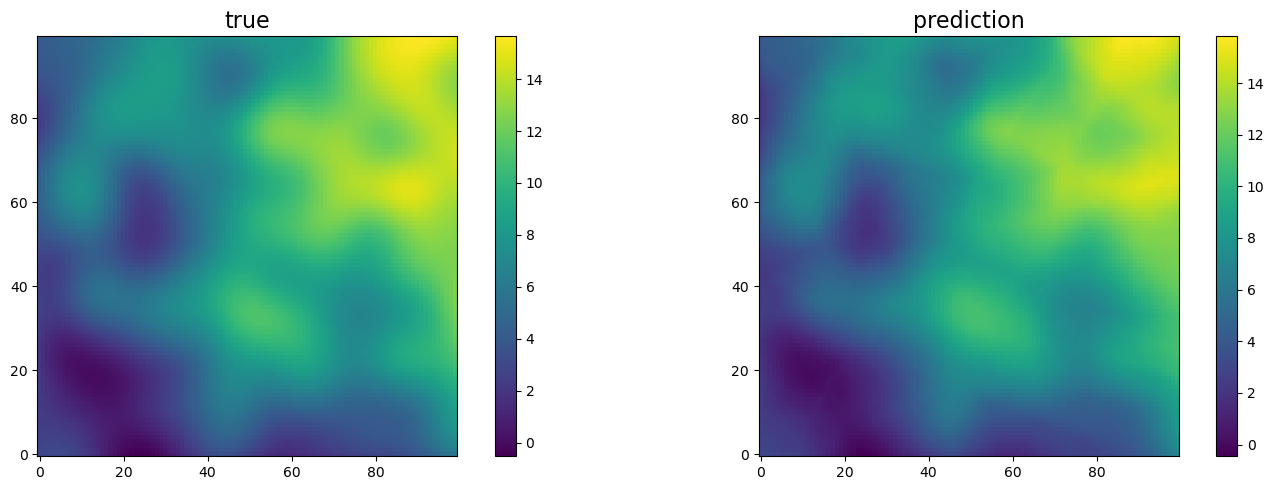

In [18]:
def visualize_field_pre(filepath):
    ##### Visualize the true and predicted random field #####
    data = pd.read_csv(filepath)
    columns=['target', 'predict']
    titles=['true', 'prediction']
    fig = plt.figure(figsize=(15,5))
    for i in range(2):
        ax = plt.subplot(1, 2, i+1)
        plt.imshow(data[columns[i]].values.reshape(100, 100))
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.title(titles[i], fontsize=16)
    plt.tight_layout()
    plt.savefig(filepath[0: filepath.rfind('/')] + '/RFresult_visualize.png', dpi=300, bbox_inches='tight')

visualize_field_pre(save_dir + '/RFresult.csv')